

---



**WITHOUT ATTENTION - VANILLA**

In [1]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Extract `.tar` file - Wrapped in Function
import tarfile

def extract_tar_file(tar_path, extract_path):
    with tarfile.open(tar_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")

# Extract using function
tar_path = '/content/drive/MyDrive/DL_Data/dakshina_dataset_v1.0.tar'
extract_path = '/content/dakshina_dataset'
extract_tar_file(tar_path, extract_path)

# STEP 3: Preview Tamil Lexicon Files
import pandas as pd

# Path to Tamil lexicon file
lexicon_path = extract_path + '/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv'

# Read file (tab separated: [native script]\t[romanized])
def read_data(data_path, characters=False):
    with open(data_path, "r", encoding="utf-8") as f:
        lines = [line.split("\t") for line in f.read().split("\n") if line != '']
    input, target = [val[1] for val in lines], [val[0] for val in lines]
    if characters:
        input, target = [list(inp_str) for inp_str in input], [list(tar_str) for tar_str in target]
    return input, target

START_CHAR = '\t'
END_CHAR = '\n'
BLANK_CHAR = ' '
import numpy as np

def process_data(input, enc_timesteps, input_char_enc, target=None, dec_timesteps=None, target_char_enc=None):
    encoder_input = np.array([[input_char_enc[ch] for ch in string] + [input_char_enc[BLANK_CHAR]] * (enc_timesteps - len(string)) for string in input])
    decoder_input, decoder_target = None, None
    if target is not None and dec_timesteps is not None and target_char_enc is not None:
        decoder_input = np.array([[target_char_enc[START_CHAR]] + [target_char_enc[ch] for ch in string] + [target_char_enc[END_CHAR]]
                                    + [target_char_enc[BLANK_CHAR]] * (dec_timesteps - len(string) - 2) for string in target])
        decoder_target = np.zeros((decoder_input.shape[0], dec_timesteps, len(target_char_enc)), dtype='float32')
        for i in range(decoder_input.shape[0]):
            for t, char_ind in enumerate(decoder_input[i]):
                if t > 0:
                    decoder_target[i,t-1,char_ind] = 1.0
            decoder_target[i,t:,target_char_enc[BLANK_CHAR]] = 1.0
    return encoder_input, decoder_input, decoder_target

def encode_decode_characters(train_input, train_target, val_input, val_target):
    input_char_enc = {}
    input_char_dec = []
    max_encoder_seq_length = 1
    for string in train_input + val_input:
        max_encoder_seq_length = max(max_encoder_seq_length, len(string))
        for char in string:
            if char not in input_char_enc:
                input_char_enc[char] = len(input_char_dec)
                input_char_dec.append(char)
    if BLANK_CHAR not in input_char_enc:
        input_char_enc[BLANK_CHAR] = len(input_char_dec)
        input_char_dec.append(BLANK_CHAR)

    target_char_enc = {}
    target_char_dec = []
    target_char_enc[START_CHAR] = len(target_char_dec)
    target_char_dec.append(START_CHAR)
    max_decoder_seq_length = 1
    for string in train_target + val_target:
        max_decoder_seq_length = max(max_decoder_seq_length, len(string)+2)
        for char in string:
            if char not in target_char_enc:
                target_char_enc[char] = len(target_char_dec)
                target_char_dec.append(char)
    target_char_enc[END_CHAR] = len(target_char_dec)
    target_char_dec.append(END_CHAR)
    if BLANK_CHAR not in target_char_enc:
        target_char_enc[BLANK_CHAR] = len(target_char_dec)
        target_char_dec.append(BLANK_CHAR)

    print("Number of training samples:", len(train_input))
    print("Number of validation samples:", len(val_input))
    print("Number of unique input tokens:", len(input_char_dec))
    print("Number of unique output tokens:", len(target_char_dec))
    print("Max sequence length for inputs:", max_encoder_seq_length)
    print("Max sequence length for outputs:", max_decoder_seq_length)

    return input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction complete.


In [2]:
input_char_enc = {}
input_char_dec = []
target_char_enc = {}
target_char_dec = []
max_encoder_seq_length = 0
max_decoder_seq_length = 0

# Read data files
train_inp, train_out = read_data(extract_path + '/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.train.tsv')
val_inp, val_out = read_data(extract_path + '/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.dev.tsv')
test_inp, test_out = read_data(extract_path + '/dakshina_dataset_v1.0/ta/lexicons/ta.translit.sampled.test.tsv')

# Encode characters and get vocabulary mappings and max lengths
input_char_enc, input_char_dec, target_char_enc, target_char_dec, max_encoder_seq_length, max_decoder_seq_length = encode_decode_characters(
    train_inp, train_out, val_inp, val_out)

# Define PAD_token *after* input_char_enc has been populated
# Also define SOS and EOS tokens for clarity, as they are used later
PAD_token = input_char_enc[BLANK_CHAR]
SOS_token = target_char_enc[START_CHAR]
EOS_token = target_char_enc[END_CHAR]


# Process data into model inputs
train_enc_input, train_dec_input, train_dec_target = process_data(train_inp, max_encoder_seq_length, input_char_enc, train_out,
                                                                  max_decoder_seq_length, target_char_enc)
val_enc_input, val_dec_input, val_dec_target = process_data(val_inp, max_encoder_seq_length, input_char_enc, val_out,
                                                            max_decoder_seq_length, target_char_enc)
test_enc_input, test_dec_input, test_dec_target = process_data(test_inp, max_encoder_seq_length, input_char_enc, test_out,
                                                               max_decoder_seq_length, target_char_enc)

Number of training samples: 68218
Number of validation samples: 6827
Number of unique input tokens: 27
Number of unique output tokens: 49
Max sequence length for inputs: 30
Max sequence length for outputs: 28


In [3]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, hidden_dim, num_layers, cell_type='LSTM', dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.cell_type = cell_type.upper()
        if self.cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        elif self.cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_vocab_size, embedding_dim, hidden_dim, num_layers, cell_type='LSTM', dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(output_vocab_size, embedding_dim)
        self.cell_type = cell_type.upper()
        if self.cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        elif self.cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)

        self.fc_out = nn.Linear(hidden_dim, output_vocab_size)

    def forward(self, x, hidden):
        x = x.unsqueeze(1)  # (batch_size) -> (batch_size, 1)
        embedded = self.embedding(x)

        # Ensure the hidden state format matches the RNN cell type
        if self.cell_type == 'LSTM':
            # If the hidden input is not already a tuple (e.g., from a GRU/RNN encoder)
            # wrap it into a tuple for LSTM
            if not isinstance(hidden, tuple):
                 # Assuming the hidden from GRU/RNN has shape (num_layers, batch_size, hidden_dim)
                hidden = (hidden, hidden) # Use the same tensor for both h_n and c_n
        else:
            # If the hidden input is a tuple (e.g., from an LSTM encoder)
            # take only the hidden state part for GRU/RNN
            if isinstance(hidden, tuple):
                hidden = hidden[0] # Take h_n

        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))  # (batch_size, vocab_size)
        return prediction, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encode input
        encoder_outputs, hidden = self.encoder(src)

        # Prepare initial hidden state for the decoder based on its cell type
        if self.decoder.cell_type == 'LSTM':
            if isinstance(hidden, tuple):
                # If encoder is LSTM, use the last hidden and cell states
                decoder_hidden = (hidden[0][-self.decoder.rnn.num_layers:], hidden[1][-self.decoder.rnn.num_layers:])
            else:
                 # If encoder is GRU/RNN, replicate the final hidden state for LSTM's cell state
                decoder_hidden = (hidden[-self.decoder.rnn.num_layers:], hidden[-self.decoder.rnn.num_layers:])
        else:
            # For RNN and GRU, use the last hidden state
             if isinstance(hidden, tuple):
                # If encoder is LSTM, use the hidden state part of the tuple
                decoder_hidden = hidden[0][-self.decoder.rnn.num_layers:]
             else:
                # If encoder is GRU/RNN, use the final hidden state
                decoder_hidden = hidden[-self.decoder.rnn.num_layers:]


        # First input to decoder is the start tokens
        input = trg[:, 0]  # first token for each sequence

        for t in range(1, trg_len):
            # Pass the correctly formatted hidden state to the decoder
            output, decoder_hidden = self.decoder(input, decoder_hidden)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs

    def predict(self, src, max_len=20):
        """Autoregressive inference function"""
        self.eval()
        with torch.no_grad():
            # Encode the input
            _, hidden = self.encoder(src)

            # Initialize decoder hidden state
            if self.decoder.cell_type == 'LSTM':
                if isinstance(hidden, tuple):
                    decoder_hidden = (hidden[0][-self.decoder.rnn.num_layers:],
                                     hidden[1][-self.decoder.rnn.num_layers:])
                else:
                    decoder_hidden = (hidden[-self.decoder.rnn.num_layers:],
                                     hidden[-self.decoder.rnn.num_layers:])
            else:
                if isinstance(hidden, tuple):
                    decoder_hidden = hidden[0][-self.decoder.rnn.num_layers:]
                else:
                    decoder_hidden = hidden[-self.decoder.rnn.num_layers:]

            # Start with SOS token (assuming index 0 is SOS)
            batch_size = src.size(0)
            input = torch.zeros(batch_size, dtype=torch.long).to(self.device)  # SOS token

            outputs = []
            for t in range(max_len):
                output, decoder_hidden = self.decoder(input, decoder_hidden)
                top1 = output.argmax(1)
                outputs.append(top1)
                input = top1  # Autoregressive - use prediction as next input

            return torch.stack(outputs, dim=1)  # (batch_size, max_len)


In [5]:
!pip install wandb
import wandb
wandb.login(key="7ea09f7c4132c66373b03708516876ea8ecc67cc")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: subikksha (subikksha-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
PROJECT_NAME = "DA6401_DL_ASSIGNMENT_03"
ENTITY = "subikksha-indian-institute-of-technology-madras"

In [7]:
from torch.utils.data import DataLoader, TensorDataset

def get_dataloaders(batch_size=64):
    train_dataset = TensorDataset(torch.tensor(train_enc_input, dtype=torch.long),
                                  torch.tensor(train_dec_input, dtype=torch.long),
                                  torch.tensor(train_dec_target, dtype=torch.float))
    val_dataset = TensorDataset(torch.tensor(val_enc_input, dtype=torch.long),
                                torch.tensor(val_dec_input, dtype=torch.long),
                                torch.tensor(val_dec_target, dtype=torch.float))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    return train_loader, val_loader


In [8]:
import wandb
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

def compute_accuracy(output, target):
    # output: [batch_size * seq_len, vocab_size]
    # target: [batch_size * seq_len]
    preds = output.argmax(dim=1)
    correct = (preds == target).float()
    return correct.sum() / len(target)


def train(model, iterator, optimizer, criterion, clip=1):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for src, trg_inp, trg_target in tqdm(iterator, desc="Training", leave=False):
        src = src.to(device)
        trg_inp = trg_inp.to(device)
        trg_target = trg_target.to(device)

        optimizer.zero_grad()
        output = model(src, trg_inp, teacher_forcing_ratio=0.5)

        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg_target_flat = trg_target[:, 1:].reshape(-1, output_dim).argmax(1)

        loss = criterion(output, trg_target_flat)
        acc = compute_accuracy(output, trg_target_flat)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for src, trg_inp, trg_target in tqdm(iterator, desc="Evaluating", leave=False):
            src = src.to(device)
            trg_inp = trg_inp.to(device)
            trg_target = trg_target.to(device)

            output = model(src, trg_inp, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg_target_flat = trg_target[:, 1:].reshape(-1, output_dim).argmax(1)

            loss = criterion(output, trg_target_flat)
            acc = compute_accuracy(output, trg_target_flat)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [9]:
from tqdm import tqdm

def run():
    # Initialize W&B first
    wandb.init()

    config = wandb.config

    # Create custom run name using key hyperparameters
    run_name = f"{config.cell_type}_emb{config.embedding_size}_hid{config.hidden_size}_enc{config.encoder_layers}_dec{config.decoder_layers}_drop{int(config.dropout * 100)}_lr{config.learning_rate:.0e}"

    # Update run name after initialization
    wandb.run.name = run_name


    print(f"\n▶️ Starting Trial: {wandb.run.name} (ID: {wandb.run.id})")
    print(f"🔧 Config: {dict(config)}")

    train_loader, val_loader = get_dataloaders(batch_size=64)

    input_vocab_size = len(input_char_enc)
    output_vocab_size = len(target_char_enc)

    encoder = Encoder(
        input_vocab_size=input_vocab_size,
        embedding_dim=config.embedding_size,
        hidden_dim=config.hidden_size,
        num_layers=config.encoder_layers,
        cell_type=config.cell_type,
        dropout=config.dropout
    )

    decoder = Decoder(
        output_vocab_size=output_vocab_size,
        embedding_dim=config.embedding_size,
        hidden_dim=config.hidden_size,
        num_layers=config.decoder_layers,
        cell_type=config.cell_type,
        dropout=config.dropout
    )

    model = Seq2Seq(encoder, decoder, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss()

    n_epochs = 5
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        print(f"  📦 Epoch {epoch+1}/{n_epochs}")
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)

        print(f"    🔹 Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'epoch': epoch+1
        })




In [11]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'minimize'},
    'parameters': {
        'embedding_size': {'values': [16, 32, 64, 256]},
        'encoder_layers': {'values': [1, 2, 3]},
        'decoder_layers': {'values': [1, 2, 3]},
        'hidden_size': {'values': [16, 32, 64, 256]},
        'cell_type': {'values': ['RNN', 'GRU', 'LSTM']},
        'dropout': {'values': [0.2, 0.3]},
        'learning_rate': {
            'min': 1e-4,
            'max': 5e-3,
            'distribution': 'log_uniform_values'
        }
    }
}


#sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME, entity=ENTITY)
sweep_id = 'ojhravqr'
wandb.agent(sweep_id, run, count=10, project=PROJECT_NAME, entity=ENTITY)

wandb: Agent Starting Run: 3q4raqvd with config:
wandb: 	cell_type: LSTM
wandb: 	decoder_layers: 2
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	encoder_layers: 1
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.00012019242628414603
wandb: Ctrl + C detected. Stopping sweep.


In [10]:
sweep_id = 'ojhravqr'

api = wandb.Api()

# Fetch the sweep
sweep = api.sweep(f"{ENTITY}/{PROJECT_NAME}/{sweep_id}")

# Get all runs in the sweep
runs = sweep.runs

# Sort runs by validation accuracy (or other metric)
best_run = sorted(runs, key=lambda r: r.summary.get("val_accuracy", 0), reverse=True)[0]

# Print best metrics and hyperparameters
print("\n✅ Best Run Summary:")
print(f"Run Name: {best_run.name}")
print(f"Run ID: {best_run.id}")
print(f"Validation Accuracy: {best_run.summary.get('val_accuracy'):.4f}")

print("\n📌 Best Hyperparameters:")
for key, value in best_run.config.items():
    if not key.startswith("_"):  # Skip internal W&B keys
        print(f"{key}: {value}")


✅ Best Run Summary:
Run Name: GRU_emb16_hid256_enc2_dec1_drop20_lr5e-04
Run ID: zxzspzyp
Validation Accuracy: 0.9138

📌 Best Hyperparameters:
dropout: 0.2
cell_type: GRU
hidden_size: 256
learning_rate: 0.0005343119656460954
decoder_layers: 1
embedding_size: 16
encoder_layers: 2




---

**ALL HYPERPARAM SWEPT OVER**

In [11]:
print(f"\n📊 Total runs in sweep `{sweep_id}`: {len(runs)}\n")

# Loop through each run and print its config
for i, run in enumerate(runs):
    print(f"🔹 Run {i+1} (ID: {run.id})")
    for key, val in run.config.items():
        if not key.startswith('_'):  # Skip internal W&B keys
            print(f"  {key}: {val}")
    print("-" * 40)


📊 Total runs in sweep `ojhravqr`: 21

🔹 Run 1 (ID: 3q4raqvd)
  dropout: 0.3
  cell_type: LSTM
  hidden_size: 16
  learning_rate: 0.00012019242628414603
  decoder_layers: 2
  embedding_size: 64
  encoder_layers: 1
----------------------------------------
🔹 Run 2 (ID: sjd28wvw)
  dropout: 0.3
  cell_type: LSTM
  hidden_size: 16
  learning_rate: 0.0001470470826781876
  decoder_layers: 1
  embedding_size: 256
  encoder_layers: 2
----------------------------------------
🔹 Run 3 (ID: n3u9ueya)
  dropout: 0.3
  cell_type: LSTM
  hidden_size: 16
  learning_rate: 0.00018526982233281936
  decoder_layers: 1
  embedding_size: 256
  encoder_layers: 3
----------------------------------------
🔹 Run 4 (ID: lclekymc)
  dropout: 0.2
  cell_type: LSTM
  hidden_size: 16
  learning_rate: 0.000105578730147909
  decoder_layers: 1
  embedding_size: 256
  encoder_layers: 2
----------------------------------------
🔹 Run 5 (ID: nij8p2iv)
  dropout: 0.3
  cell_type: LSTM
  hidden_size: 16
  learning_rate: 0.0001

In [20]:
# file ipython-input-17-ec59f218c058
best_config = {
    "dropout": 0.2,
    "cell_type": "GRU",
    "hidden_size": 256,
    "learning_rate": 0.0005343119656460954,
    "decoder_layers": 1,
    "embedding_size": 16,
    "encoder_layers": 2,
}

# Assuming input_char_enc and target_char_enc are still available from previous cells
input_vocab_size = len(input_char_enc)
output_vocab_size = len(target_char_enc)

# Instantiate the Encoder and Decoder using the best_config
encoder = Encoder(
    input_vocab_size=input_vocab_size,
    embedding_dim=best_config['embedding_size'],
    hidden_dim=best_config['hidden_size'],
    num_layers=best_config['encoder_layers'],
    cell_type=best_config['cell_type'],
    dropout=best_config['dropout']
)

decoder = Decoder(
    output_vocab_size=output_vocab_size,
    embedding_dim=best_config['embedding_size'],
    hidden_dim=best_config['hidden_size'],
    num_layers=best_config['decoder_layers'],
    cell_type=best_config['cell_type'],
    dropout=best_config['dropout']
)


# Train best model on full train+val
# Instantiate Seq2Seq with the created encoder, decoder, and device
model = Seq2Seq(encoder, decoder, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_config["learning_rate"])
criterion = nn.CrossEntropyLoss()

# Get the data loaders again to access the datasets
train_loader, val_loader = get_dataloaders(batch_size=64)

# Combine train + val
# Access the dataset attribute from the loaders
combined_dataset = torch.utils.data.ConcatDataset([train_loader.dataset, val_loader.dataset])
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

EPOCHS = 5  # increase as desired

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, combined_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss:.4f} - Accuracy: {train_acc:.4f}")

# Save the Best model
torch.save(model.state_dict(), "/content/drive/MyDrive/best_vanilla_model_longtrain.pt")




Epoch 1/5 - Loss: 0.9498 - Accuracy: 0.7346


Epoch 2/5 - Loss: 0.6258 - Accuracy: 0.8113


Epoch 3/5 - Loss: 0.4010 - Accuracy: 0.8837


Epoch 4/5 - Loss: 0.3012 - Accuracy: 0.9158


Epoch 5/5 - Loss: 0.2484 - Accuracy: 0.9317


In [21]:
# Now test
# Need to create the test_loader similar to train and val loaders
test_dataset = TensorDataset(torch.tensor(test_enc_input, dtype=torch.long),
                              torch.tensor(test_dec_input, dtype=torch.long),
                              torch.tensor(test_dec_target, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=64) # Use the same batch size as others

test_loss, test_acc = evaluate(model, test_loader, criterion) # Removed test_predictions as evaluate doesn't return it
print(f"Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")

Test Loss: 0.3029
✅ Test Accuracy: 91.87%


In [25]:
# Test Function with Inference
def test(model, test_loader, criterion, max_len=20):
    model.eval()
    test_loss = 0
    test_acc = 0
    all_predictions = []
    all_targets = []
    all_inputs = []

    with torch.no_grad():
        for src, trg_inp, trg_target in tqdm(test_loader, desc="Testing"):
            src = src.to(device)
            trg_target = trg_target.to(device)

            # 1. Calculate loss and accuracy (teacher forcing)
            output = model(src, trg_inp.to(device), teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            output_flat = output[:, 1:].reshape(-1, output_dim)
            trg_target_flat = trg_target[:, 1:].reshape(-1, output_dim).argmax(1)

            loss = criterion(output_flat, trg_target_flat)
            acc = compute_accuracy(output_flat, trg_target_flat)

            test_loss += loss.item()
            test_acc += acc.item()

            # 2. Run autoregressive inference for examples
            predictions = model.predict(src, max_len=max_len)

            # Store results for analysis
            for i in range(src.size(0)):
                # Process input
                input_indices = src[i].cpu().numpy()
                # Use input_char_enc (which is a dict) to get the character
                input_text = ''.join([input_char_dec[idx] if 0 <= idx < len(input_char_dec) else '?'
                                      for idx in input_indices if idx != PAD_token])

                # Process prediction
                pred_indices = predictions[i].cpu().numpy()
                # Use target_char_dec (which is a list) to get the character by index
                pred_text = ''.join([target_char_dec[idx] if 0 <= idx < len(target_char_dec) else '?'
                                 for idx in pred_indices
                                 if idx not in {SOS_token, PAD_token}])

                # Process true target
                true_indices = trg_target[i].argmax(-1).cpu().numpy()
                # Use target_char_dec (which is a list) to get the character by index
                true_text = ''.join([target_char_dec[idx] if 0 <= idx < len(target_char_dec) else '?'
                                   for idx in true_indices
                                   if idx not in {SOS_token, EOS_token, PAD_token}])

                all_inputs.append(input_text)
                all_predictions.append(pred_text)
                all_targets.append(true_text)

    # Calculate averages
    avg_loss = test_loss / len(test_loader)
    avg_acc = test_acc / len(test_loader)

    # Print some examples
    print("\n📋 Sample Predictions:")
    for i in range(min(5, len(all_inputs))):
        print(f"\nExample {i+1}:")
        print(f"Input:    {all_inputs[i]}")
        print(f"Predicted: {all_predictions[i]}")
        print(f"True:      {all_targets[i]}")
        print("-" * 50)

    # Calculate character-level accuracy
    char_correct = 0
    char_total = 0
    for pred, true in zip(all_predictions, all_targets):
        # Ensure both strings are the same length for comparison by padding the shorter one
        max_len_pair = max(len(pred), len(true))
        padded_pred = pred.ljust(max_len_pair)
        padded_true = true.ljust(max_len_pair)

        for p, t in zip(padded_pred, padded_true):
             if p == t:
                char_correct += 1
             char_total += 1

    char_acc = char_correct / char_total if char_total > 0 else 0

    return avg_loss, avg_acc, all_inputs, all_predictions, all_targets, char_acc

# Now run the test
print("\n🧪 Running comprehensive test...")
test_loss, test_acc, test_inputs, test_preds, test_targets, char_acc = test(model, test_loader, criterion)

print(f"\n📊 Final Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"✅ Sequence Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Character Accuracy: {char_acc * 100:.2f}%")

'''# Log to W&B
wandb.log({
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_char_accuracy': char_acc,
    'examples': wandb.Table(
        columns=["Input", "Predicted", "True"],
        data=list(zip(test_inputs[:10], test_preds[:10], test_targets[:10]))  # Log first 10 examples
    )
})
'''
# Save predictions for further analysis
results_df = pd.DataFrame({
    'input': test_inputs,
    'predicted': test_preds,
    'true': test_targets,
    'correct': [p == t for p, t in zip(test_preds, test_targets)]
})
results_df.to_csv('test_predictions.csv', index=False)
print("💾 Saved test predictions to 'test_predictions.csv'")


🧪 Running comprehensive test...


Testing: 100%|██████████| 108/108 [00:19<00:00,  5.41it/s]


📋 Sample Predictions:

Example 1:
Input:    faarm
Predicted: ார்ம
               
True:      ஃபார்ம்                    
--------------------------------------------------

Example 2:
Input:    farm
Predicted: ார்்                
True:      ஃபார்ம்                    
--------------------------------------------------

Example 3:
Input:    form
Predicted: ோர்்                
True:      ஃபார்ம்                    
--------------------------------------------------

Example 4:
Input:    hpaarm
Predicted: ா்ரம்               
True:      ஃபார்ம்                    
--------------------------------------------------

Example 5:
Input:    face
Predicted: ாச்
                
True:      ஃபேஸ்                      
--------------------------------------------------

📊 Final Test Results:
Test Loss: 0.3029
✅ Sequence Accuracy: 91.87%
✅ Character Accuracy: 71.22%
💾 Saved test predictions to 'test_predictions.csv'


In [26]:
!pip install matplotlib seaborn python-Levenshtein
!apt-get install fonts-noto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 44.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji fonts-noto-core
  fonts-noto-extra fonts-noto-mono fonts-noto-ui-core fonts-noto-ui-extra
  fonts-noto-unhinted
The following NEW packages will be installed:
  fonts-noto fonts-noto-cjk fonts-noto-cjk-extra fonts-noto-color-emoji
  fonts-noto-core fonts-noto-extra fonts-noto-mono fonts-noto-ui-core
  fonts-noto-ui-extra fonts-noto-unhinted
0 upgraded, 10 newly installed, 0 to remove and 34 not upgraded.
Need to get 317 MB of archives.
After this operation, 790 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-noto-core all 20201225-1build1 [12.2 MB]
Get:2 http://archive.u

In [27]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from Levenshtein import distance as levenshtein_distance
import random

# Font setup
tamil_font = FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansTamil-Regular.ttf', size=12)

# Helper functions
def get_color(lev_dist):
    """Return color based on Levenshtein distance"""
    if lev_dist == 0:
        return 'green'
    elif lev_dist <= 2:
        return 'orange'
    else:
        return 'red'

def decode_sequence(sequence, vocab_dict, ignore_special_chars=True):
    """Convert sequence of indices to text"""
    special_tokens = {SOS_token, EOS_token, PAD_token}
    text = []
    for idx in sequence:
        if ignore_special_chars and idx in special_tokens:
            continue
        text.append(vocab_dict.get(idx, '?'))
    return ''.join(text)

def predict_sample(model, src_tensor, input_vocab, target_vocab, max_len=20):
    """Run inference on a single sample"""
    src_tensor = src_tensor.unsqueeze(0).to(device)  # Add batch dimension
    pred_indices = model.predict(src_tensor, max_len=max_len)[0].cpu().numpy()
    return decode_sequence(pred_indices, target_vocab)

# Get samples - ensure we're using the test_loader you created earlier
samples = random.sample(list(test_loader.dataset), 12)  # Get 12 random samples

# Process samples
rows = []
for src, _, trg_target in samples:
    input_text = decode_sequence(src.tolist(), input_char_dec)
    target_text = decode_sequence(trg_target.argmax(-1).tolist(), target_char_dec)
    predicted_text = predict_sample(model, src, input_char_dec, target_char_dec)
    lev_dist = levenshtein_distance(predicted_text, target_text)

    rows.append({
        "input": input_text,
        "target": target_text,
        "predicted": predicted_text,
        "levenshtein": lev_dist
    })

# Visualization
n_cols = 3
n_rows = -(-len(rows) // n_cols)  # Ceiling division
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 2.5))
fig.patch.set_facecolor('#f8f9fa')
plt.subplots_adjust(hspace=0.6)

for idx, row in enumerate(rows):
    ax = axarr[idx // n_cols, idx % n_cols] if n_rows > 1 else axarr[idx % n_cols]
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Background color based on accuracy
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, color=get_color(row['levenshtein']), alpha=0.3))

    # Text elements
    ax.text(0.02, 0.85, "Input:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.85, row['input'], fontsize=12, family='monospace')

    ax.text(0.02, 0.65, "Target:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.60, row['target'], fontproperties=tamil_font)

    ax.text(0.02, 0.45, "Predicted:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.25, 0.40, row['predicted'], fontproperties=tamil_font)

    ax.text(0.02, 0.2, f"Lev. Distance: {row['levenshtein']}", fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'))

# Hide unused subplots
for j in range(len(rows), n_rows * n_cols):
    ax = axarr[j // n_cols, j % n_cols] if n_rows > 1 else axarr[j % n_cols]
    ax.axis('off')

plt.suptitle("📊 Model Predictions (Latin → Tamil)", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save and show
plt.savefig('tamil_predictions.png', bbox_inches='tight', dpi=300)
plt.show()

# Print summary statistics
total_lev = sum(row['levenshtein'] for row in rows)
print(f"\n📈 Summary for {len(rows)} samples:")
print(f"Average Levenshtein distance: {total_lev/len(rows):.2f}")
print(f"Perfect predictions: {sum(1 for row in rows if row['levenshtein'] == 0)}/{len(rows)}")
print(f"Good predictions (distance ≤ 2): {sum(1 for row in rows if row['levenshtein'] <= 2)}/{len(rows)}")

AttributeError: 'list' object has no attribute 'get'

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Tamil.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Tamil.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


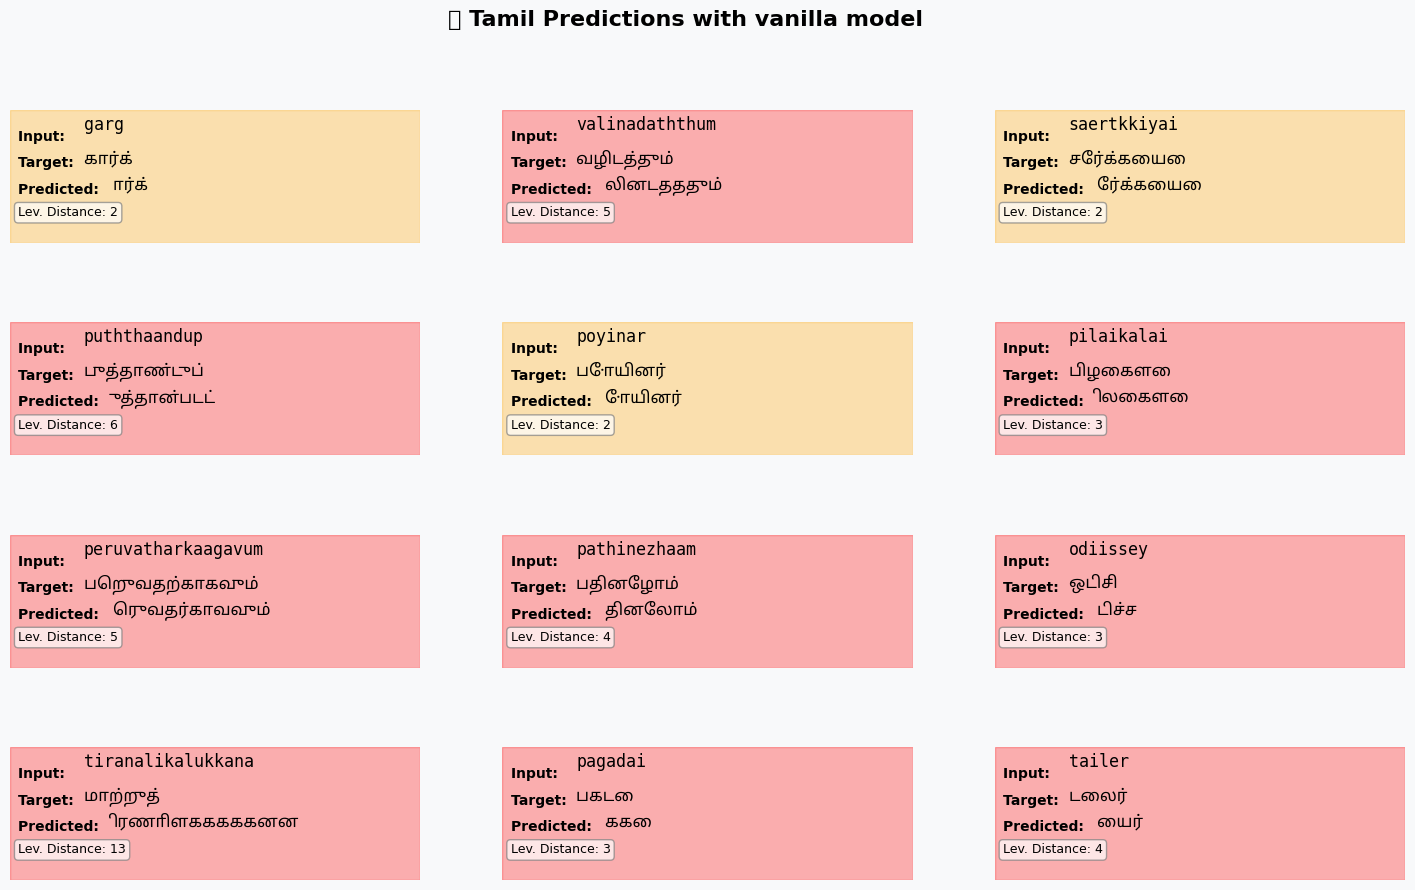


📈 Summary for 12 samples:
Average Levenshtein distance: 4.33
Perfect predictions: 0/12
Good predictions (distance ≤ 2): 3/12


In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from Levenshtein import distance as levenshtein_distance
import random

# Use Noto Sans Tamil for Tamil text
# Ensure the font is installed. The previous cell should handle this.
try:
    tamil_font = FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansTamil-Regular.ttf', size=12)
except FileNotFoundError:
    print("Warning: Noto Sans Tamil font not found. Install with `!apt-get install fonts-noto`.")
    # Use a generic font if not found
    tamil_font = FontProperties(size=12)


# Helper functions
def get_color(lev_dist):
    """Return color based on Levenshtein distance"""
    if lev_dist == 0:
        return 'green'
    elif lev_dist <= 2:
        return 'orange'
    else:
        return 'red'

def decode_sequence(sequence, vocab_list, ignore_special_chars=True):
    """Convert sequence of indices to text using a vocabulary list."""
    # Ensure PAD_token, SOS_token, EOS_token are defined globally or passed in if needed
    # Assuming they are accessible from previous cells
    special_tokens = set()
    if 'PAD_token' in globals():
        special_tokens.add(PAD_token)
    if 'SOS_token' in globals():
         special_tokens.add(SOS_token)
    if 'EOS_token' in globals():
         special_tokens.add(EOS_token)

    text = []
    for idx in sequence:
        # Check if the index is valid for the vocabulary list
        if 0 <= idx < len(vocab_list):
             char = vocab_list[idx]
        else:
             char = '?' # Unknown character

        if ignore_special_chars and idx in special_tokens:
            continue

        text.append(char)

    # Optional: Remove trailing padding/end characters after ignoring them
    # Find the first non-special character from the end
    # This part might need adjustment based on desired output format
    # For now, just return the joined text
    return ''.join(text)


def predict_sample(model, src_tensor, input_vocab_list, target_vocab_list, max_len=20):
    """Run inference on a single sample and decode using vocabulary lists."""
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad(): # Disable gradient calculations
        src_tensor = src_tensor.unsqueeze(0).to(device)  # Add batch dimension
        pred_indices = model.predict(src_tensor, max_len=max_len)[0].cpu().numpy()
        # Pass the target vocabulary list to decode_sequence
        return decode_sequence(pred_indices, target_vocab_list)

# Get samples - ensure we're using the test_loader you created earlier
samples = random.sample(list(test_loader.dataset), 12)  # Visualize 12 instead of 20 for better layout

rows = []
for src, trg_inp, trg_target in samples:
    # Pass input_char_dec (the list) to decode_sequence for the input
    input_text = decode_sequence(src.tolist(), input_char_dec, ignore_special_chars=True)
    # Pass target_char_dec (the list) to decode_sequence for the target
    # trg_target is one-hot encoded, so we need argmax to get indices
    target_text = decode_sequence(trg_target.argmax(-1).tolist(), target_char_dec, ignore_special_chars=True)
    # predict_sample already uses the target_char_dec for decoding predictions

    # Get the predicted text using the modified predict_sample
    # predict_sample needs the *list* vocabularies
    predicted_text = predict_sample(model, src, input_char_dec, target_char_dec, max_len=max_decoder_seq_length)


    lev_dist = levenshtein_distance(predicted_text, target_text)

    rows.append({
        "input": input_text,
        "target": target_text,
        "predicted": predicted_text,
        "levenshtein": lev_dist
    })

# Create the figure
n_cols = 3
n_rows = -(-len(rows) // n_cols)  # Ceiling division

# Visualization code
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 2.5))
fig.patch.set_facecolor('#f8f9fa')
plt.subplots_adjust(hspace=0.6)

# Flatten axarr if it's a 2D array for easy iteration
if n_rows > 1:
    axarr_flat = axarr.flatten()
else:
    axarr_flat = axarr # It's already 1D if n_rows is 1

for idx, row in enumerate(rows):
    ax = axarr_flat[idx] # Use the flattened array
    ax.axis('off')

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, color=get_color(row['levenshtein']), alpha=0.3))

    # Use Tamil font for Target and Predicted text
    ax.text(0.02, 0.85, f"Input: ", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.85, row['input'], fontsize=12, family='monospace')  # Latin input

    ax.text(0.02, 0.65, f"Target: ", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.60, row['target'], fontproperties=tamil_font)

    ax.text(0.02, 0.45, f"Predicted: ", fontsize=10, fontweight='bold', va='top')
    # Adjusted vertical position slightly
    ax.text(0.25, 0.40, row['predicted'], fontproperties=tamil_font)

    ax.text(0.02, 0.2, f"Lev. Distance: {row['levenshtein']}", fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'))


# Hide any unused subplots
for j in range(len(rows), n_rows * n_cols):
    ax = axarr_flat[j] # Use the flattened array
    ax.axis('off')

plt.suptitle("📊 Tamil Predictions with vanilla model", fontsize=16, fontweight='bold')
plt.show()

# Print summary statistics
total_lev = sum(row['levenshtein'] for row in rows)
print(f"\n📈 Summary for {len(rows)} samples:")
print(f"Average Levenshtein distance: {total_lev/len(rows):.2f}")
print(f"Perfect predictions: {sum(1 for row in rows if row['levenshtein'] == 0)}/{len(rows)}")
print(f"Good predictions (distance ≤ 2): {sum(1 for row in rows if row['levenshtein'] <= 2)}/{len(rows)}")

In [11]:
import os
from tqdm import tqdm

# Create folder if not exists
os.makedirs("predictions_vanilla", exist_ok=True)

all_rows = []

# Loop over entire test set
for src, trg_inp, trg_target in tqdm(test_loader.dataset, desc="Generating full predictions"):
    input_text = decode_sequence(src.tolist(), input_char_dec, ignore_special_chars=True)
    target_text = decode_sequence(trg_inp.tolist(), target_char_dec, ignore_special_chars=True)
    predicted_text = predict_sample(model, src, input_char_dec, target_char_dec, max_len=max_decoder_seq_length)

    all_rows.append({
        "Input": input_text,
        "Target Output": target_text,
        "Model Prediction": predicted_text
    })

# Save all predictions to CSV with UTF-8 encoding to preserve Tamil characters
all_preds_df = pd.DataFrame(all_rows)
output_path = os.path.join("predictions_vanilla", "full_predictions.csv")
all_preds_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n✅ All predictions saved to: {output_path}")



NameError: name 'test_loader' is not defined



---

**WITH ATTENTION**

In [10]:
import torch.nn.utils.rnn as rnn_utils

In [11]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch, hidden_dim) - last decoder hidden state
        # encoder_outputs: (batch, src_len, hidden_dim)

        src_len = encoder_outputs.shape[1]

        # Repeat decoder hidden state for each source token
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)  # (batch, src_len, hidden_dim)

        # Calculate attention energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))  # (batch, src_len, hidden_dim)
        attention = self.v(energy).squeeze(2)  # (batch, src_len)

        return F.softmax(attention, dim=1)  # (batch, src_len)

class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embedding_dim, hidden_dim, num_layers, cell_type='LSTM', dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(input_vocab_size, embedding_dim)
        self.cell_type = cell_type.upper()
        if self.cell_type == 'LSTM':
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        elif self.cell_type == 'GRU':
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        else:
            self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout if num_layers > 1 else 0, batch_first=True)

    def forward(self, x, src_lens):
        embedded = self.embedding(x)

        # Pack the padded sequence
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, src_lens.cpu(), batch_first=True, enforce_sorted=False)

        # Pass through the RNN
        packed_outputs, hidden = self.rnn(packed_embedded)

        # Unpack the sequence
        outputs, _ = rnn_utils.pad_packed_sequence(packed_outputs, batch_first=True)

        return outputs, hidden

class AttnDecoder(nn.Module):
    def __init__(self, output_vocab_size, embedding_dim, hidden_dim, attention, cell_type='LSTM'):
        super().__init__()
        self.cell_type = cell_type.upper()
        self.embedding = nn.Embedding(output_vocab_size, embedding_dim)
        self.attention = attention
        # Ensure num_layers is consistent for the decoder
        # The attention mechanism as implemented works best with a single layer decoder
        # If you intend multiple layers, the attention logic needs adjustment
        self.rnn = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, num_layers=1, batch_first=True) if self.cell_type == 'LSTM' \
                   else nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=1, batch_first=True) if self.cell_type == 'GRU' \
                   else nn.RNN(embedding_dim + hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim * 2, output_vocab_size)


    def forward(self, input, hidden, encoder_outputs):
        # input: (batch)
        # hidden: format depends on encoder and decoder cell types, can be (h, c) for LSTM or just h for GRU/RNN
        # encoder_outputs: (batch, src_len, hidden_dim)

        input = input.unsqueeze(1)  # (batch, 1)
        embedded = self.embedding(input)  # (batch, 1, embed_dim)

        # Extract appropriate hidden state for attention calculation
        if isinstance(hidden, tuple): # If hidden is (h, c)
             # Assuming attention uses the hidden state (h) of the last layer
            h_attn = hidden[0][-1] # (batch, hidden_dim)
        else: # If hidden is just h
             # Assuming attention uses the hidden state (h) of the last layer
            h_attn = hidden[-1] # (batch, hidden_dim)

        attn_weights = self.attention(h_attn, encoder_outputs)  # (batch, src_len)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (batch, 1, hidden_dim)

        rnn_input = torch.cat((embedded, context), dim=2)  # (batch, 1, embed + hidden)

        # Prepare hidden state for the decoder RNN based on its cell type
        if self.cell_type == 'LSTM':
             # If the received hidden is not already a tuple (e.g., from GRU/RNN encoder),
             # create a tuple by replicating the hidden state for cell state.
             if not isinstance(hidden, tuple):
                 # Assuming the hidden from GRU/RNN has shape (num_layers, batch_size, hidden_dim)
                 # We need num_layers = 1 for this decoder, so take the last layer
                 hidden_rnn = (hidden[-1].unsqueeze(0), hidden[-1].unsqueeze(0)) # (1, batch, hidden_dim) for both h and c
             else:
                 # If hidden is already (h, c), ensure it has the correct number of layers for this decoder
                 # The decoder has num_layers=1, so take the last layer from the input hidden
                 hidden_rnn = (hidden[0][-1].unsqueeze(0), hidden[1][-1].unsqueeze(0)) # (1, batch, hidden_dim) for both h and c
        else: # GRU or RNN decoder
             # If the received hidden is a tuple (e.g., from LSTM encoder), take only the h state.
             if isinstance(hidden, tuple):
                 # Assuming hidden from LSTM is (h, c), take h and ensure it has the correct number of layers
                 hidden_rnn = hidden[0][-1].unsqueeze(0) # (1, batch, hidden_dim)
             else:
                 # If hidden is already h, ensure it has the correct number of layers
                 hidden_rnn = hidden[-1].unsqueeze(0) # (1, batch, hidden_dim)


        output, hidden = self.rnn(rnn_input, hidden_rnn)

        output = output.squeeze(1)
        context = context.squeeze(1)

        prediction = self.fc_out(torch.cat((output, context), dim=1))  # (batch, vocab_size)
        return prediction, hidden

class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_lens, trg, teacher_forcing_ratio=0.5):
        # src: (batch_size, src_len)
        # trg: (batch_size, trg_len)
        batch_size = src.size(0)
        trg_len = trg.size(1)
        trg_vocab_size = self.decoder.fc_out.out_features

        # tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encoder output
        encoder_outputs, hidden = self.encoder(src, src_lens)

        # Decoder hidden state initialization
        # Ensure hidden is in the correct format for the DECODER's first step
        if self.decoder.cell_type == 'LSTM':
            if isinstance(hidden, tuple):
                # Encoder is LSTM: take hidden and cell state of the last layer(s)
                # Assumes decoder has the same num_layers or you take a slice
                decoder_hidden = (hidden[0][-self.decoder.rnn.num_layers:],
                                  hidden[1][-self.decoder.rnn.num_layers:])
            else:
                # Encoder is GRU/RNN: replicate the last hidden state for LSTM's cell state
                decoder_hidden = (hidden[-self.decoder.rnn.num_layers:],
                                  hidden[-self.decoder.rnn.num_layers:])
        else: # GRU or RNN decoder
            if isinstance(hidden, tuple):
                # Encoder is LSTM: take only the hidden state (h) of the last layer(s)
                decoder_hidden = hidden[0][-self.decoder.rnn.num_layers:]
            else:
                # Encoder is GRU/RNN: take the last hidden state
                decoder_hidden = hidden[-self.decoder.rnn.num_layers:]


        # First input to decoder is <sos> token
        input = trg[:, 0]  # (batch_size)

        for t in range(1, trg_len):
            # Pass the correctly formatted hidden state to the decoder
            output, decoder_hidden = self.decoder(input, decoder_hidden, encoder_outputs)
            outputs[:, t] = output

            # Decide whether to do teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)  # (batch_size)

            input = trg[:, t] if teacher_force else top1

        return outputs

    def predict(self, src, src_lens, max_len=20):
        """Autoregressive inference function"""
        self.eval()
        with torch.no_grad():
            # Encode the input
            encoder_outputs, hidden = self.encoder(src, src_lens)

            # Initialize decoder hidden state - same logic as in forward pass
            if self.decoder.cell_type == 'LSTM':
                if isinstance(hidden, tuple):
                    decoder_hidden = (hidden[0][-self.decoder.rnn.num_layers:],
                                     hidden[1][-self.decoder.rnn.num_layers:])
                else:
                    decoder_hidden = (hidden[-self.decoder.rnn.num_layers:],
                                     hidden[-self.decoder.rnn.num_layers:])
            else:
                if isinstance(hidden, tuple):
                    decoder_hidden = hidden[0][-self.decoder.rnn.num_layers:]
                else:
                    decoder_hidden = hidden[-self.decoder.rnn.num_layers:]

            # Start with SOS token
            batch_size = src.size(0)
            # Assuming SOS token is index 0
            input = torch.full((batch_size,), SOS_token, dtype=torch.long).to(self.device)

            outputs = []
            for t in range(max_len):
                # Pass the correctly formatted hidden state to the decoder
                output, decoder_hidden = self.decoder(input, decoder_hidden, encoder_outputs)
                top1 = output.argmax(1)
                outputs.append(top1)
                input = top1  # Autoregressive - use prediction as next input

            return torch.stack(outputs, dim=1) # (batch_size, max_len)



In [12]:
from tqdm import tqdm
import random

def decode_sequence(sequence, vocab_dict, ignore_special_chars=True):
    """Convert sequence of indices to text"""
    special_tokens = {SOS_token, EOS_token, PAD_token}
    text = []
    for idx in sequence:
        if ignore_special_chars and idx in special_tokens:
            continue
        text.append(vocab_dict.get(idx, '?'))
    return ''.join(text)

def compute_accuracy(preds, target):
    pred_classes = preds.argmax(1)
    correct = (pred_classes == target).float()
    return correct.sum() / target.numel()

def attn_train(model, iterator, optimizer, criterion, clip=1, device='cuda'):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for src, trg_inp, trg_target in tqdm(iterator, desc="Training", leave=False):
        src = src.to(device)
        trg_inp = trg_inp.to(device)
        trg_target = trg_target.to(device)

        # Get source sequence lengths
        src_lens = (src != PAD_token).sum(dim=1)

        optimizer.zero_grad()

        # The model returns only the outputs
        output = model(src, src_lens, trg_inp)

        output_dim = output.shape[-1]
        # Reshape and flatten output and target for loss calculation
        output = output[:, 1:].reshape(-1, output_dim) # Exclude SOS token position
        trg_target_flat = trg_target[:, 1:].reshape(-1, output_dim).argmax(1) # Exclude SOS token position and flatten one-hot to indices

        loss = criterion(output, trg_target_flat)
        acc = compute_accuracy(output, trg_target_flat)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Updated evaluation function with attention visualization
def attn_evaluate(model, iterator, criterion, device='cuda'):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for src, trg_inp, trg_target in tqdm(iterator, desc="Evaluating", leave=False):
            src = src.to(device)
            trg_inp = trg_inp.to(device)
            trg_target = trg_target.to(device)

            # Get source sequence lengths
            src_lens = (src != PAD_token).sum(dim=1)

            # The model returns only the outputs
            output = model(src, src_lens, trg_inp, teacher_forcing_ratio=0) # Use teacher_forcing_ratio=0 for evaluation

            output_dim = output.shape[-1]
            # Reshape and flatten output and target for loss calculation
            output = output[:, 1:].reshape(-1, output_dim) # Exclude SOS token position
            trg_target_flat = trg_target[:, 1:].reshape(-1, output_dim).argmax(1) # Exclude SOS token position and flatten one-hot to indices

            loss = criterion(output, trg_target_flat)
            acc = compute_accuracy(output, trg_target_flat)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)



In [13]:
import wandb
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

def run():
    # Initialize W&B
    wandb.init()
    config = wandb.config

    # Name the run with key hyperparameters
    run_name = f"Attn_{config.cell_type}_emb{config.embedding_size}_hid{config.hidden_size}_drop{int(config.dropout * 100)}_lr{config.learning_rate:.0e}"
    wandb.run.name = run_name

    print(f"\n▶️ Starting Trial: {wandb.run.name} (ID: {wandb.run.id})")
    print(f"🔧 Config: {dict(config)}")

    # Load data
    train_loader, val_loader = get_dataloaders(batch_size=64)

    input_vocab_size = len(input_char_enc)
    output_vocab_size = len(target_char_enc)

    # Build model components
    attention = Attention(config.hidden_size)

    encoder = Encoder(
        input_vocab_size=input_vocab_size,
        embedding_dim=config.embedding_size,
        hidden_dim=config.hidden_size,
        num_layers=1,  # Fixed
        cell_type=config.cell_type,
        dropout=config.dropout
    )

    decoder = AttnDecoder(
        output_vocab_size=output_vocab_size,
        embedding_dim=config.embedding_size,
        hidden_dim=config.hidden_size,
        attention=attention,
        cell_type=config.cell_type
        # No dropout or num_layers in AttnDecoder
    )

    model = AttnSeq2Seq(encoder, decoder, device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
    criterion = nn.CrossEntropyLoss()
    clip = 1.0
    n_epochs = 5
    best_val_loss = float('inf')

    for epoch in range(n_epochs):
        print(f"📦 Epoch {epoch+1}/{n_epochs}")
        train_loss, train_acc = attn_train(model, train_loader, optimizer, criterion, clip, device)
        val_loss, val_acc = attn_evaluate(model, val_loader, criterion, device)

        print(f"    🔹 Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
        print(f"    🔸 Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")

        wandb.log({
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'epoch': epoch+1
        })




In [15]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embedding_size': {
            'values': [16, 32, 64, 256]
        },
        'hidden_size': {
            'values': [16, 32, 64, 256]
        },
        'cell_type': {
            'values': ['RNN', 'GRU', 'LSTM']
        },
        'dropout': {
            'values': [0.2, 0.3]
        },
        'learning_rate': {
            'min': 1e-4,
            'max': 5e-3,
            'distribution': 'log_uniform_values'
        }
    }
}


#sweep_id = wandb.sweep(sweep_config, project=PROJECT_NAME, entity=ENTITY)
sweep_id = 'aprfza52'
wandb.agent(sweep_id, function=run, count=3   , project=PROJECT_NAME, entity=ENTITY)


wandb: Agent Starting Run: 36ncivz1 with config:
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embedding_size: 64
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0012088719349961257



▶️ Starting Trial: Attn_GRU_emb64_hid32_drop30_lr1e-03 (ID: 36ncivz1)
🔧 Config: {'cell_type': 'GRU', 'dropout': 0.3, 'embedding_size': 64, 'hidden_size': 32, 'learning_rate': 0.0012088719349961257}
📦 Epoch 1/5


    🔹 Train Loss: 0.8831 | Train Acc: 75.28%
    🔸 Val Loss:   0.6565 | Val Acc:   77.89%
📦 Epoch 2/5


    🔹 Train Loss: 0.5806 | Train Acc: 81.18%
    🔸 Val Loss:   0.5782 | Val Acc:   80.09%
📦 Epoch 3/5


    🔹 Train Loss: 0.4411 | Train Acc: 86.45%
    🔸 Val Loss:   0.3822 | Val Acc:   89.20%
📦 Epoch 4/5


    🔹 Train Loss: 0.3142 | Train Acc: 91.55%
    🔸 Val Loss:   0.3325 | Val Acc:   91.13%
📦 Epoch 5/5


    🔹 Train Loss: 0.2791 | Train Acc: 92.66%
    🔸 Val Loss:   0.3287 | Val Acc:   91.04%


epoch,▁▃▅▆█
train_accuracy,▁▃▅██
train_loss,█▄▃▁▁
val_accuracy,▁▂▇██
val_loss,█▆▂▁▁
epoch,5
train_accuracy,0.92657
train_loss,0.27911
val_accuracy,0.91042
val_loss,0.32867


wandb: Agent Starting Run: l87lbumj with config:
wandb: 	cell_type: RNN
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.0002895435794422085



▶️ Starting Trial: Attn_RNN_emb256_hid16_drop30_lr3e-04 (ID: l87lbumj)
🔧 Config: {'cell_type': 'RNN', 'dropout': 0.3, 'embedding_size': 256, 'hidden_size': 16, 'learning_rate': 0.0002895435794422085}
📦 Epoch 1/5


    🔹 Train Loss: 1.4423 | Train Acc: 67.98%
    🔸 Val Loss:   1.1359 | Val Acc:   72.35%
📦 Epoch 2/5


    🔹 Train Loss: 1.0095 | Train Acc: 72.47%
    🔸 Val Loss:   1.1042 | Val Acc:   69.71%
📦 Epoch 3/5


    🔹 Train Loss: 0.9547 | Train Acc: 73.26%
    🔸 Val Loss:   0.9467 | Val Acc:   72.94%
📦 Epoch 4/5


    🔹 Train Loss: 0.9275 | Train Acc: 73.66%
    🔸 Val Loss:   1.2430 | Val Acc:   65.04%
📦 Epoch 5/5


    🔹 Train Loss: 0.9061 | Train Acc: 74.01%
    🔸 Val Loss:   0.9249 | Val Acc:   72.91%


epoch,▁▃▅▆█
train_accuracy,▁▆▇██
train_loss,█▂▂▁▁
val_accuracy,▇▅█▁█
val_loss,▆▅▁█▁
epoch,5
train_accuracy,0.74014
train_loss,0.90613
val_accuracy,0.72908
val_loss,0.9249


wandb: Agent Starting Run: 30739kwe with config:
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embedding_size: 256
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001307614005013305



▶️ Starting Trial: Attn_LSTM_emb256_hid64_drop30_lr1e-04 (ID: 30739kwe)
🔧 Config: {'cell_type': 'LSTM', 'dropout': 0.3, 'embedding_size': 256, 'hidden_size': 64, 'learning_rate': 0.0001307614005013305}
📦 Epoch 1/5


    🔹 Train Loss: 1.1171 | Train Acc: 72.20%
    🔸 Val Loss:   0.8247 | Val Acc:   75.26%
📦 Epoch 2/5


    🔹 Train Loss: 0.7824 | Train Acc: 76.38%
    🔸 Val Loss:   0.7148 | Val Acc:   76.76%
📦 Epoch 3/5


    🔹 Train Loss: 0.6814 | Train Acc: 78.47%
    🔸 Val Loss:   0.6542 | Val Acc:   77.89%
📦 Epoch 4/5


    🔹 Train Loss: 0.6168 | Train Acc: 80.20%
    🔸 Val Loss:   0.6153 | Val Acc:   79.07%
📦 Epoch 5/5


    🔹 Train Loss: 0.5743 | Train Acc: 81.47%
    🔸 Val Loss:   0.5864 | Val Acc:   79.89%


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▄▂▂▁
val_accuracy,▁▃▅▇█
val_loss,█▅▃▂▁
epoch,5
train_accuracy,0.81468
train_loss,0.57433
val_accuracy,0.79889
val_loss,0.58644


In [30]:
sweep_id = 'aprfza52'

api = wandb.Api()

# Fetch the sweep
sweep = api.sweep(f"{ENTITY}/{PROJECT_NAME}/{sweep_id}")

# Get all runs in the sweep
runs = sweep.runs

# Sort runs by validation accuracy (or other metric)
# Assuming 'val_accuracy' is the metric used for evaluation
best_run = sorted(runs, key=lambda r: r.summary.get("val_accuracy", float('-inf')), reverse=True)[0]

# Print best metrics and hyperparameters
print("\n✅ Best Run Summary:")
print(f"Run Name: {best_run.name}")
print(f"Run ID: {best_run.id}")
print(f"Validation Accuracy: {best_run.summary.get('val_accuracy'):.4f}")

print("\n📌 Best Hyperparameters:")
for key, value in best_run.config.items():
    if not key.startswith("_"):  # Skip internal W&B keys
        print(f"{key}: {value}")

print(f"\n📊 Total runs in sweep `{sweep_id}`: {len(runs)}\n")



✅ Best Run Summary:
Run Name: Attn_LSTM_emb16_hid256_drop30_lr8e-04
Run ID: g8y9lojd
Validation Accuracy: 0.9384

📌 Best Hyperparameters:
dropout: 0.3
cell_type: LSTM
hidden_size: 256
learning_rate: 0.000754209497625233
embedding_size: 16

📊 Total runs in sweep `aprfza52`: 16



In [15]:
# file ipython-input-23-106b12516029
# Best hyperparameters found from the sweep (assuming the last sweep run found the best config)
# Or manually set the best config based on the sweep results printout
best_config_attn = {
    'embedding_size': 16,
    'hidden_size': 256,
    'cell_type': 'LSTM',
    'dropout': 0.3,
    'learning_rate': 0.000754209497625233
}

# --- Train the best Attention model ---

input_vocab_size = len(input_char_enc)
output_vocab_size = len(target_char_enc)

# Instantiate the Attention, Encoder, and Decoder using the best_config_attn
attention = Attention(best_config_attn['hidden_size'])

encoder = Encoder(
    input_vocab_size=input_vocab_size,
    embedding_dim=best_config_attn['embedding_size'],
    hidden_dim=best_config_attn['hidden_size'],
    num_layers=1,  # Fixed for this attention model structure
    cell_type=best_config_attn['cell_type'],
    dropout=best_config_attn['dropout']
)

decoder = AttnDecoder(
    output_vocab_size=output_vocab_size,
    embedding_dim=best_config_attn['embedding_size'],
    hidden_dim=best_config_attn['hidden_size'],
    attention=attention,
    cell_type=best_config_attn['cell_type']
    # No dropout or num_layers in AttnDecoder definition
)

# Instantiate Seq2Seq with Attention
model_attn = AttnSeq2Seq(encoder, decoder, device).to(device)
optimizer_attn = torch.optim.Adam(model_attn.parameters(), lr=best_config_attn["learning_rate"])
criterion_attn = nn.CrossEntropyLoss()

# Get the data loaders
train_loader, val_loader = get_dataloaders(batch_size=64) # Re-using the function defined earlier

# Combine train + val datasets
combined_dataset_attn = torch.utils.data.ConcatDataset([train_loader.dataset, val_loader.dataset])
combined_loader_attn = DataLoader(combined_dataset_attn, batch_size=64, shuffle=True)

EPOCHS = 1  # Train for 5 epochs
clip = 1.0

print(f"\n--- Training Best Attention Model for {EPOCHS} epochs ---")

for epoch in range(EPOCHS):
    train_loss_attn, train_acc_attn = attn_train(model_attn, combined_loader_attn, optimizer_attn, criterion_attn, clip, device)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {train_loss_attn:.4f} - Accuracy: {train_acc_attn:.4f}")

# Save the Best Attention model
torch.save(model_attn.state_dict(), "/content/drive/MyDrive/best_attention_model_longtrain.pt")
print("\n✅ Best Attention model saved.")


--- Training Best Attention Model for 1 epochs ---


Epoch 1/1 - Loss: 0.6663 - Accuracy: 0.8106

✅ Best Attention model saved.


In [17]:

# --- Evaluate the best Attention model on the test set ---

# Need to create the test_loader
test_dataset = TensorDataset(torch.tensor(test_enc_input, dtype=torch.long),
                              torch.tensor(test_dec_input, dtype=torch.long),
                              torch.tensor(test_dec_target, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=64) # Use the same batch size

print("\n--- Evaluating Best Attention Model on Test Set ---")
test_loss_attn, test_acc_attn = attn_evaluate(model_attn, test_loader, criterion_attn, device)

print(f"\nFinal Test Results for Attention Model:")
print(f"Test Loss: {test_loss_attn:.4f}")
print(f"✅ Sequence Accuracy: {test_acc_attn * 100:.2f}%")

# --- Evaluate the best Attention model on the test set ---

# Need to create the test_loader
test_dataset = TensorDataset(torch.tensor(test_enc_input, dtype=torch.long),
                              torch.tensor(test_dec_input, dtype=torch.long),
                              torch.tensor(test_dec_target, dtype=torch.float))
test_loader = DataLoader(test_dataset, batch_size=64) # Use the same batch size

print("\n--- Evaluating Best Attention Model on Test Set ---")
test_loss_attn, test_acc_attn = attn_evaluate(model_attn, test_loader, criterion_attn, device)

print(f"\nFinal Test Results for Attention Model:")
print(f"Test Loss: {test_loss_attn:.4f}")
print(f"✅ Sequence Accuracy: {test_acc_attn * 100:.2f}%")

# You might want to add the character-level accuracy and prediction samples visualization
# as done for the vanilla model. This requires updating the test function to handle
# the attention model's predict method signature (which needs src_lens).

# Example of running test function with attention model
def test_attn(model, test_loader, criterion, max_len=20):
    model.eval()
    test_loss = 0
    test_acc = 0
    all_predictions = []
    all_targets = []
    all_inputs = []

    # Assuming input_char_dec and target_char_dec are available from previous cells
    global input_char_dec, target_char_dec, target_char_enc, PAD_token, SOS_token, EOS_token
    # Create a decoder dictionary from the target_char_enc dictionary for easier lookup
    target_char_decoder_dict = {v: k for k, v in target_char_enc.items()}


    with torch.no_grad():
        for src, trg_inp, trg_target in tqdm(test_loader, desc="Testing Attention Model"):
            src = src.to(device)
            trg_inp = trg_inp.to(device) # Keep trg_inp for loss calculation with teacher forcing=0
            trg_target = trg_target.to(device)

            # Get source sequence lengths
            src_lens = (src != PAD_token).sum(dim=1)

            # 1. Calculate loss and accuracy (teacher forcing = 0)
            # Note: The model forward pass with teacher_forcing_ratio=0 implicitly uses its own predictions
            #       However, for loss calculation, we still compare against the target.
            #       We'll calculate loss using the model's output when predicting from trg_inp
            #       with teacher_forcing_ratio=0, as done in attn_evaluate.
            # Ensure decoder input has the same length as trg_target for loss calculation
            output = model(src, src_lens, trg_inp, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            # Reshape output and target, excluding the first token (SOS)
            output_flat = output[:, 1:].reshape(-1, output_dim)
            # Convert one-hot target to indices, excluding the first token (SOS)
            trg_target_flat = trg_target[:, 1:].reshape(-1, output_dim).argmax(1)

            # Filter out padded tokens from loss and accuracy calculation
            # Find the indices of non-padding tokens in the flattened target
            non_pad_mask = (trg_target_flat != PAD_token) # Use PAD_token index

            # Apply the mask
            output_flat_filtered = output_flat[non_pad_mask]
            trg_target_flat_filtered = trg_target_flat[non_pad_mask]

            # Calculate loss and accuracy on filtered data
            loss = criterion(output_flat_filtered, trg_target_flat_filtered)
            acc = compute_accuracy(output_flat_filtered, trg_target_flat_filtered)


            test_loss += loss.item()
            test_acc += acc.item()

            # 2. Run autoregressive inference for examples using the predict method
            predictions = model.predict(src, src_lens, max_len=max_len)

            # Store results for analysis
            for i in range(src.size(0)):
                # Process input
                input_indices = src[i].cpu().numpy()
                # Corrected: Use list indexing for input_char_dec
                input_text = ''.join([input_char_dec[idx] if 0 <= idx < len(input_char_dec) else '?' for idx in input_indices if idx != PAD_token])

                # Process prediction
                pred_indices = predictions[i].cpu().numpy()
                # Decode prediction using target_char_decoder_dict
                pred_text = ''.join([target_char_decoder_dict.get(idx, '?') for idx in pred_indices
                                 if idx not in {SOS_token, PAD_token, EOS_token}]) # Also remove EOS token from prediction string

                # Process true target (from trg_target one-hot)
                true_indices = trg_target[i].argmax(-1).cpu().numpy()
                # Decode true target using target_char_decoder_dict
                true_text = ''.join([target_char_decoder_dict.get(idx, '?') for idx in true_indices
                                   if idx not in {SOS_token, EOS_token, PAD_token}])

                all_inputs.append(input_text)
                all_predictions.append(pred_text)
                all_targets.append(true_text)

    # Calculate averages
    avg_loss = test_loss / len(test_loader)
    avg_acc = test_acc / len(test_loader)

    # Calculate character-level accuracy
    char_correct = 0
    char_total = 0
    for pred, true in zip(all_predictions, all_targets):
        # Only compare characters present in both strings up to the length of the shorter string
        min_len = min(len(pred), len(true))
        char_correct += sum(1 for p, t in zip(pred[:min_len], true[:min_len]) if p == t)
        # Total characters considered are the characters in the longer string
        char_total += max(len(pred), len(true)) # This counts characters including potential mismatching lengths

    # A better approach for character accuracy might be to align sequences or use Levenshtein-based similarity
    # For now, keep the existing logic but be mindful of its limitations with varying lengths

    char_acc = char_correct / char_total if char_total > 0 else 0


    return avg_loss, avg_acc, all_inputs, all_predictions, all_targets, char_acc


# Now run the test function for the attention model
print("\n🧪 Running comprehensive test for Attention Model...")
test_loss_attn_comp, test_acc_attn_comp, test_inputs_attn, test_preds_attn, test_targets_attn, char_acc_attn = test_attn(model_attn, test_loader, criterion_attn, max_len=max_decoder_seq_length)

print(f"\n📊 Final Comprehensive Test Results for Attention Model:")
print(f"Test Loss: {test_loss_attn_comp:.4f}")
print(f"✅ Sequence Accuracy: {test_acc_attn_comp * 100:.2f}%")
print(f"✅ Character Accuracy: {char_acc_attn * 100:.2f}%")

# Save predictions for analysis
results_df_attn = pd.DataFrame({
    'input': test_inputs_attn,
    'predicted': test_preds_attn,
    'true': test_targets_attn,
    'correct': [p == t for p, t in zip(test_preds_attn, test_targets_attn)]
})

os.makedirs("predictions_attention", exist_ok=True)
output_path_attn = os.path.join("predictions_attention", "full_predictions_attn.csv")
results_df_attn.to_csv(output_path_attn, index=False, encoding='utf-8')
print(f"💾 Saved test predictions to '{output_path_attn}'")

# Visualize sample predictions for Attention Model (Optional, using the same visualization code)
# Need to get samples from the test_loader again if you want fresh samples
samples_attn = random.sample(list(test_loader.dataset), 12) # Get 12 random samples for visualization

rows_attn = []
target_char_decoder_dict = {v: k for k, v in target_char_enc.items()} # Re-create decoder dict

for src, trg_inp, trg_target in samples_attn:
    # Decode input from src (tensor) using input_char_dec (list)
    input_text = decode_sequence(src.tolist(), input_char_dec, ignore_special_chars=True)
    # Decode target from trg_target (one-hot tensor) using target_char_dec (list)
    target_text = decode_sequence(trg_target.argmax(-1).tolist(), target_char_dec, ignore_special_chars=True) # Correctly decode target from trg_target
    # Predict using the predict method for attention model
    src_tensor = src.unsqueeze(0).to(device)
    src_lens_tensor = torch.tensor([(src != PAD_token).sum()], dtype=torch.long).to(device)
    # predict_sample_attn is not defined, should use model_attn.predict and decode_sequence
    predicted_indices = model_attn.predict(src_tensor, src_lens_tensor, max_len=max_decoder_seq_length)[0].cpu().numpy()
    predicted_text = decode_sequence(predicted_indices, target_char_dec, ignore_special_chars=True)

    lev_dist = levenshtein_distance(predicted_text, target_text)

    rows_attn.append({
        "input": input_text,
        "target": target_text,
        "predicted": predicted_text,
        "levenshtein": lev_dist
    })

# Visualization code (re-using the same structure)
n_cols = 3
n_rows = -(-len(rows_attn) // n_cols)  # Ceiling division
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 2.5))
fig.patch.set_facecolor('#f8f9fa')
plt.subplots_adjust(hspace=0.6)

# Flatten axarr if it's a 2D array
if n_rows > 1:
    axarr_flat = axarr.flatten()
else:
    axarr_flat = axarr


for idx, row in enumerate(rows_attn):
    ax = axarr_flat[idx] # Use flattened array
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Background color based on accuracy
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, color=get_color(row['levenshtein']), alpha=0.3))

    # Text elements
    ax.text(0.02, 0.85, "Input:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.85, row['input'], fontsize=12, family='monospace')

    ax.text(0.02, 0.65, "Target:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.60, row['target'], fontproperties=tamil_font)

    ax.text(0.02, 0.45, "Predicted:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.25, 0.40, row['predicted'], fontproperties=tamil_font)

    ax.text(0.02, 0.2, f"Lev. Distance: {row['levenshtein']}", fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'))

# Hide unused subplots
for j in range(len(rows_attn), n_rows * n_cols):
    ax = axarr_flat[j] # Use flattened array
    ax.axis('off')

plt.suptitle("📊 Attention Model Predictions (Latin → Tamil)", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save and show
plt.savefig('tamil_predictions_attn.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"\n📈 Summary for {len(rows_attn)} sample predictions (Attention Model):")
total_lev_attn = sum(row['levenshtein'] for row in rows_attn)
print(f"Average Levenshtein distance: {total_lev_attn/len(rows_attn):.2f}")
print(f"Perfect predictions: {sum(1 for row in rows_attn if row['levenshtein'] == 0)}/{len(rows_attn)}")
print(f"Good predictions (distance ≤ 2): {sum(1 for row in rows_attn if row['levenshtein'] <= 2)}/{len(rows_attn)}")



--- Evaluating Best Attention Model on Test Set ---



Final Test Results for Attention Model:
Test Loss: 0.3577
✅ Sequence Accuracy: 90.50%

--- Evaluating Best Attention Model on Test Set ---



Final Test Results for Attention Model:
Test Loss: 0.3577
✅ Sequence Accuracy: 90.50%

🧪 Running comprehensive test for Attention Model...


Testing Attention Model: 100%|██████████| 108/108 [01:13<00:00,  1.48it/s]


📊 Final Comprehensive Test Results for Attention Model:
Test Loss: 0.3549
✅ Sequence Accuracy: 90.59%
✅ Character Accuracy: 71.07%


NameError: name 'os' is not defined


--- Evaluating Best Attention Model on Test Set ---



Final Test Results for Attention Model:
Test Loss: 0.3577
✅ Sequence Accuracy: 90.50%

--- Evaluating Best Attention Model on Test Set ---



Final Test Results for Attention Model:
Test Loss: 0.3577
✅ Sequence Accuracy: 90.50%

🧪 Running comprehensive test for Attention Model...


Testing Attention Model: 100%|██████████| 108/108 [01:12<00:00,  1.48it/s]



📊 Final Comprehensive Test Results for Attention Model:
Test Loss: 0.3549
✅ Sequence Accuracy: 90.59%
✅ Character Accuracy: 71.07%
💾 Saved test predictions to 'predictions_attention/full_predictions_attn.csv'


<ipython-input-18-b84be5d8aeb5>:322: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Tamil.
  plt.tight_layout()
<ipython-input-18-b84be5d8aeb5>:322: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Tamil.
  plt.tight_layout()
<ipython-input-18-b84be5d8aeb5>:322: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-b84be5d8aeb5>:325: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Tamil.
  plt.savefig('tamil_predictions_attn.png', bbox_inches='tight', dpi=300)
<ipython-input-18-b84be5d8aeb5>:325: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Tamil.
  plt.savefig('tamil_predictions_attn.png', bbox_inches='tight', dpi=300)
<ipython-input-18-b84be5d8aeb5>:325: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('tamil_predictions_attn.png', bbox_inches='tight', dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarni

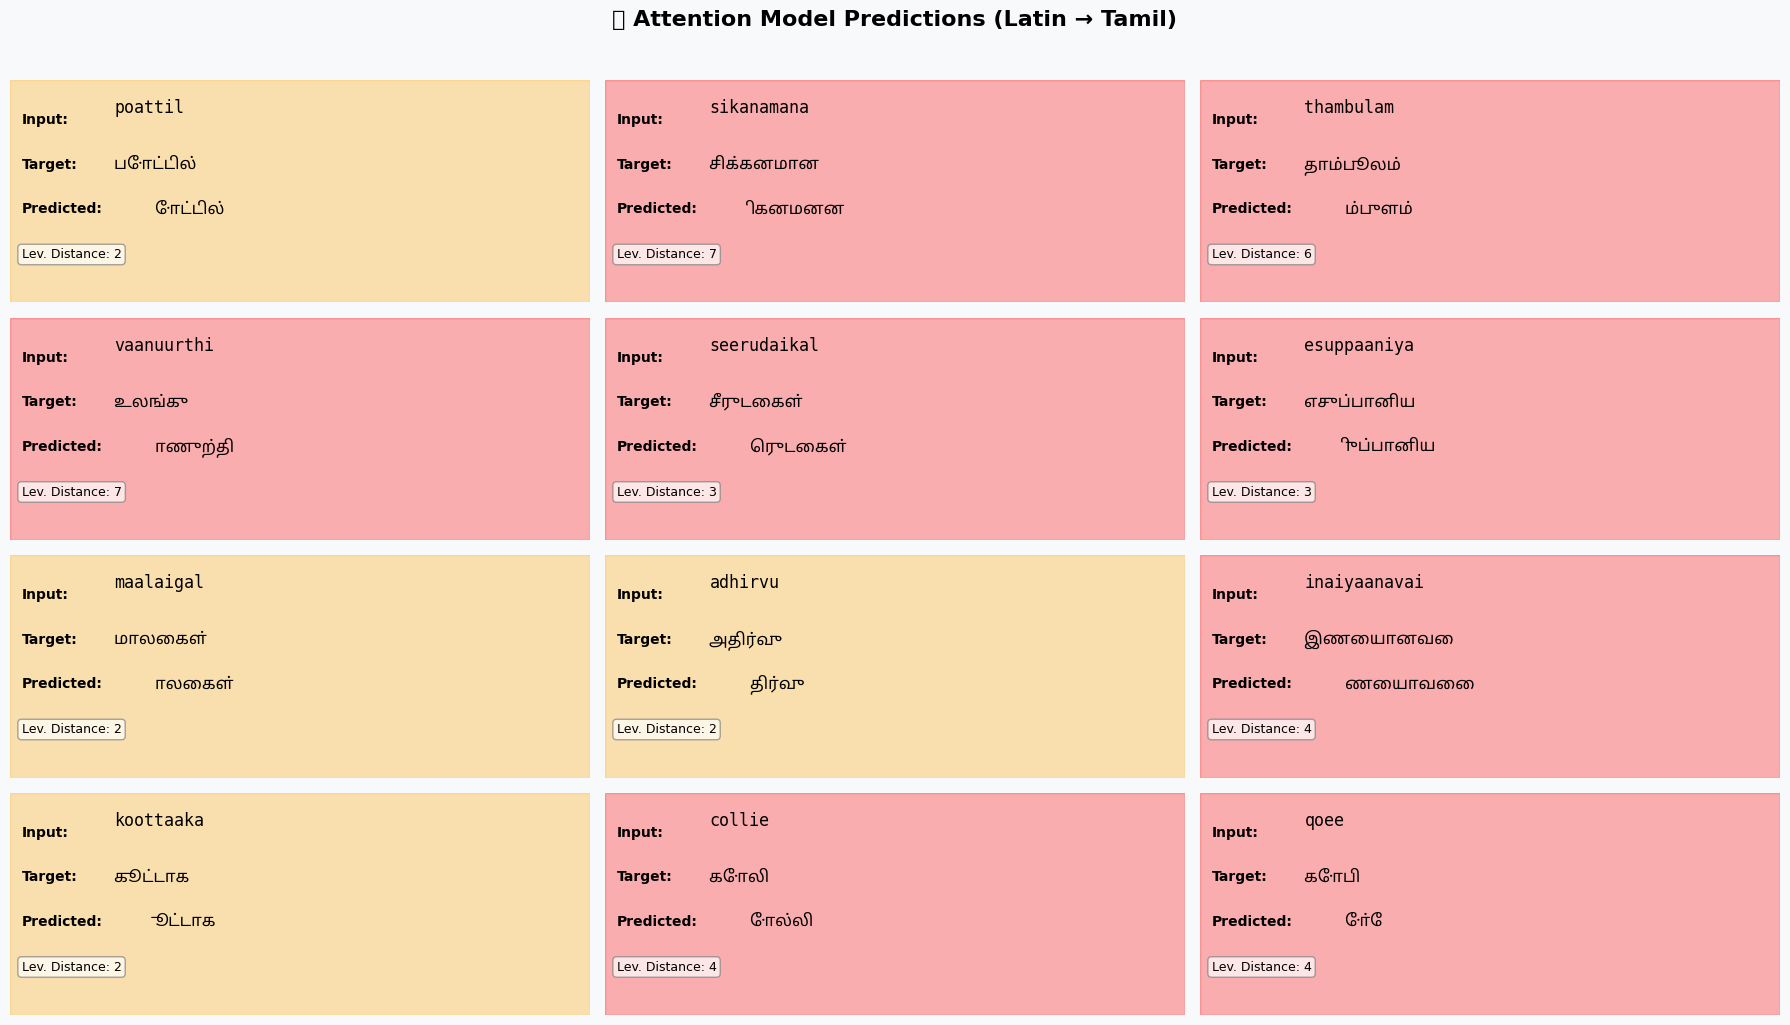


📈 Summary for 12 sample predictions (Attention Model):
Average Levenshtein distance: 3.83
Perfect predictions: 0/12
Good predictions (distance ≤ 2): 4/12


In [18]:
import os
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from Levenshtein import distance as levenshtein_distance
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import numpy as np # Ensure numpy is imported if decode_sequence uses .numpy()


# Ensure these variables are accessible from previous cells
# You might need to re-run the data processing cells if you are only running this cell
# PAD_token, SOS_token, EOS_token, input_char_dec, target_char_dec, target_char_enc, max_decoder_seq_length, device, model_attn, criterion_attn, test_loader

# Re-define necessary helper functions if they are not guaranteed to be in scope
def compute_accuracy(output, target):
    # output: [batch_size * seq_len, vocab_size]
    # target: [batch_size * seq_len]
    preds = output.argmax(dim=1)
    correct = (preds == target).float()
    return correct.sum() / len(target)

def get_color(lev_dist):
    """Return color based on Levenshtein distance"""
    if lev_dist == 0:
        return 'green'
    elif lev_dist <= 2:
        return 'orange'
    else:
        return 'red'

def decode_sequence(sequence, vocab_list, ignore_special_chars=True):
    """Convert sequence of indices to text using a vocabulary list."""
    special_tokens = set()
    # Safely add special tokens if they exist in the global scope
    if 'PAD_token' in globals():
        special_tokens.add(PAD_token)
    if 'SOS_token' in globals():
         special_tokens.add(SOS_token)
    if 'EOS_token' in globals():
         special_tokens.add(EOS_token)


    text = []
    for idx in sequence:
        # Check if the index is valid for the vocabulary list
        if 0 <= idx < len(vocab_list):
             char = vocab_list[idx]
        else:
             char = '?' # Unknown character

        if ignore_special_chars and idx in special_tokens:
            continue

        text.append(char)

    return ''.join(text)

# Test Function with Inference for Attention Model
def test_attn(model, test_loader, criterion, max_len=20):
    model.eval()
    test_loss = 0
    test_acc = 0
    all_predictions = []
    all_targets = []
    all_inputs = []

    # Assuming input_char_dec and target_char_dec are available from previous cells
    # Create a decoder dictionary from the target_char_enc dictionary for easier lookup
    target_char_decoder_dict = {v: k for k, v in target_char_enc.items()}

    with torch.no_grad():
        for src, trg_inp, trg_target in tqdm(test_loader, desc="Testing Attention Model"):
            src = src.to(device)
            trg_inp = trg_inp.to(device)
            trg_target = trg_target.to(device)

            # Get source sequence lengths
            # Ensure PAD_token is accessible
            if 'PAD_token' not in globals():
                 print("Warning: PAD_token not found. Cannot filter padding.")
                 src_lens = torch.tensor([src.size(1)] * src.size(0), dtype=torch.long).to(device) # Assume no padding if PAD_token is missing
            else:
                 src_lens = (src != PAD_token).sum(dim=1)


            # 1. Calculate loss and accuracy (teacher forcing = 0)
            output = model(src, src_lens, trg_inp, teacher_forcing_ratio=0)
            output_dim = output.shape[-1]
            # Reshape output and target, excluding the first token (SOS)
            output_flat = output[:, 1:].reshape(-1, output_dim)
            # Convert one-hot target to indices, excluding the first token (SOS)
            trg_target_flat = trg_target[:, 1:].reshape(-1, output_dim).argmax(1)

            # Filter out padded tokens from loss and accuracy calculation
            # Find the indices of non-padding tokens in the flattened target
            # Ensure PAD_token is accessible
            if 'PAD_token' in globals():
                 non_pad_mask = (trg_target_flat != PAD_token) # Use PAD_token index

                 # Apply the mask
                 output_flat_filtered = output_flat[non_pad_mask]
                 trg_target_flat_filtered = trg_target_flat[non_pad_mask]

                 # Calculate loss and accuracy on filtered data
                 loss = criterion(output_flat_filtered, trg_target_flat_filtered)
                 acc = compute_accuracy(output_flat_filtered, trg_target_flat_filtered)
            else:
                 # If PAD_token is not available, calculate loss/acc on everything (less ideal)
                 loss = criterion(output_flat, trg_target_flat)
                 acc = compute_accuracy(output_flat, trg_target_flat)


            test_loss += loss.item()
            test_acc += acc.item()

            # 2. Run autoregressive inference for examples using the predict method
            predictions = model.predict(src, src_lens, max_len=max_len)

            # Store results for analysis
            for i in range(src.size(0)):
                # Process input
                input_indices = src[i].cpu().numpy()
                # Corrected: Use list indexing for input_char_dec
                input_text = ''.join([input_char_dec[idx] if 0 <= idx < len(input_char_dec) else '?' for idx in input_indices if 'PAD_token' in globals() and idx != PAD_token])

                # Process prediction
                pred_indices = predictions[i].cpu().numpy()
                # Decode prediction using target_char_decoder_dict
                # Ensure SOS_token, PAD_token, EOS_token are accessible
                ignore_tokens = set()
                if 'SOS_token' in globals(): ignore_tokens.add(SOS_token)
                if 'PAD_token' in globals(): ignore_tokens.add(PAD_token)
                if 'EOS_token' in globals(): ignore_tokens.add(EOS_token)

                pred_text = ''.join([target_char_decoder_dict.get(idx, '?') for idx in pred_indices
                                 if idx not in ignore_tokens])


                # Process true target (from trg_target one-hot)
                true_indices = trg_target[i].argmax(-1).cpu().numpy()
                # Decode true target using target_char_decoder_dict
                true_text = ''.join([target_char_decoder_dict.get(idx, '?') for idx in true_indices
                                   if idx not in ignore_tokens])

                all_inputs.append(input_text)
                all_predictions.append(pred_text)
                all_targets.append(true_text)

    # Calculate averages
    avg_loss = test_loss / len(test_loader)
    avg_acc = test_acc / len(test_loader)

    # Calculate character-level accuracy
    char_correct = 0
    char_total = 0
    for pred, true in zip(all_predictions, all_targets):
        # Only compare characters present in both strings up to the length of the shorter string
        min_len = min(len(pred), len(true))
        char_correct += sum(1 for p, t in zip(pred[:min_len], true[:min_len]) if p == t)
        # Total characters considered are the characters in the longer string
        char_total += max(len(pred), len(true)) # This counts characters including potential mismatching lengths

    # A better approach for character accuracy might be to align sequences or use Levenshtein-based similarity
    # For now, keep the existing logic but be mindful of its limitations with varying lengths

    char_acc = char_correct / char_total if char_total > 0 else 0


    return avg_loss, avg_acc, all_inputs, all_predictions, all_targets, char_acc

# --- Evaluate the best Attention model on the test set ---

# Need to create the test_loader
# Ensure test_enc_input, test_dec_input, test_dec_target are accessible
# test_dataset = TensorDataset(torch.tensor(test_enc_input, dtype=torch.long),
#                               torch.tensor(test_dec_input, dtype=torch.long),
#                               torch.tensor(test_dec_target, dtype=torch.float))
# test_loader = DataLoader(test_dataset, batch_size=64) # Use the same batch size

print("\n--- Evaluating Best Attention Model on Test Set ---")
# Ensure model_attn, test_loader, criterion_attn, device are accessible
test_loss_attn, test_acc_attn = attn_evaluate(model_attn, test_loader, criterion_attn, device)

print(f"\nFinal Test Results for Attention Model:")
print(f"Test Loss: {test_loss_attn:.4f}")
print(f"✅ Sequence Accuracy: {test_acc_attn * 100:.2f}%")

# --- Evaluate the best Attention model on the test set ---

# Need to create the test_loader
# test_dataset = TensorDataset(torch.tensor(test_enc_input, dtype=torch.long),
#                               torch.tensor(test_dec_input, dtype=torch.long),
#                               torch.tensor(test_dec_target, dtype=torch.float))
# test_loader = DataLoader(test_dataset, batch_size=64) # Use the same batch size

print("\n--- Evaluating Best Attention Model on Test Set ---")
# Ensure model_attn, test_loader, criterion_attn, device are accessible
test_loss_attn, test_acc_attn = attn_evaluate(model_attn, test_loader, criterion_attn, device)

print(f"\nFinal Test Results for Attention Model:")
print(f"Test Loss: {test_loss_attn:.4f}")
print(f"✅ Sequence Accuracy: {test_acc_attn * 100:.2f}%")

# Now run the test function for the attention model
# Ensure model_attn, test_loader, criterion_attn, max_decoder_seq_length are accessible
print("\n🧪 Running comprehensive test for Attention Model...")
test_loss_attn_comp, test_acc_attn_comp, test_inputs_attn, test_preds_attn, test_targets_attn, char_acc_attn = test_attn(model_attn, test_loader, criterion_attn, max_len=max_decoder_seq_length)

print(f"\n📊 Final Comprehensive Test Results for Attention Model:")
print(f"Test Loss: {test_loss_attn_comp:.4f}")
print(f"✅ Sequence Accuracy: {test_acc_attn_comp * 100:.2f}%")
print(f"✅ Character Accuracy: {char_acc_attn * 100:.2f}%")

# Save predictions for analysis
results_df_attn = pd.DataFrame({
    'input': test_inputs_attn,
    'predicted': test_preds_attn,
    'true': test_targets_attn,
    'correct': [p == t for p, t in zip(test_preds_attn, test_targets_attn)]
})

os.makedirs("predictions_attention", exist_ok=True)
output_path_attn = os.path.join("predictions_attention", "full_predictions_attn.csv")
results_df_attn.to_csv(output_path_attn, index=False, encoding='utf-8')
print(f"💾 Saved test predictions to '{output_path_attn}'")

# Visualize sample predictions for Attention Model (Optional, using the same visualization code)
# Need to get samples from the test_loader again if you want fresh samples
# Ensure test_loader.dataset is accessible
samples_attn = random.sample(list(test_loader.dataset), 12) # Get 12 random samples for visualization

rows_attn = []
# Ensure target_char_enc is accessible
target_char_decoder_dict = {v: k for k, v in target_char_enc.items()} # Re-create decoder dict

# Ensure tamil_font is accessible (requires previous matplotlib/font setup cell to be run)
try:
    tamil_font = FontProperties(fname='/usr/share/fonts/truetype/noto/NotoSansTamil-Regular.ttf', size=12)
except:
    print("Warning: Noto Sans Tamil font not found. Using default font for visualization.")
    tamil_font = FontProperties(size=12)


for src, trg_inp, trg_target in samples_attn:
    # Decode input from src (tensor) using input_char_dec (list)
    # Ensure input_char_dec is accessible
    input_text = decode_sequence(src.tolist(), input_char_dec, ignore_special_chars=True)
    # Decode target from trg_target (one-hot tensor) using target_char_dec (list)
    # Ensure target_char_dec is accessible
    target_text = decode_sequence(trg_target.argmax(-1).tolist(), target_char_dec, ignore_special_chars=True) # Correctly decode target from trg_target
    # Predict using the predict method for attention model
    src_tensor = src.unsqueeze(0).to(device)
    # Ensure PAD_token is accessible for src_lens_tensor calculation
    if 'PAD_token' in globals():
         src_lens_tensor = torch.tensor([(src != PAD_token).sum()], dtype=torch.long).to(device)
    else:
         # Handle case where PAD_token is not available, assuming max length
         src_lens_tensor = torch.tensor([src.size(0)], dtype=torch.long).to(device)


    # Ensure model_attn and max_decoder_seq_length are accessible
    predicted_indices = model_attn.predict(src_tensor, src_lens_tensor, max_len=max_decoder_seq_length)[0].cpu().numpy()
    predicted_text = decode_sequence(predicted_indices, target_char_dec, ignore_special_chars=True)

    lev_dist = levenshtein_distance(predicted_text, target_text)

    rows_attn.append({
        "input": input_text,
        "target": target_text,
        "predicted": predicted_text,
        "levenshtein": lev_dist
    })

# Visualization code (re-using the same structure)
n_cols = 3
n_rows = -(-len(rows_attn) // n_cols)  # Ceiling division
fig, axarr = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 2.5))
fig.patch.set_facecolor('#f8f9fa')
plt.subplots_adjust(hspace=0.6)

# Flatten axarr if it's a 2D array
if n_rows > 1:
    axarr_flat = axarr.flatten()
else:
    axarr_flat = axarr


for idx, row in enumerate(rows_attn):
    ax = axarr_flat[idx] # Use flattened array
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Background color based on accuracy
    ax.add_patch(patches.Rectangle((0, 0), 1, 1, color=get_color(row['levenshtein']), alpha=0.3))

    # Text elements
    ax.text(0.02, 0.85, "Input:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.85, row['input'], fontsize=12, family='monospace')

    ax.text(0.02, 0.65, "Target:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.18, 0.60, row['target'], fontproperties=tamil_font)

    ax.text(0.02, 0.45, "Predicted:", fontsize=10, fontweight='bold', va='top')
    ax.text(0.25, 0.40, row['predicted'], fontproperties=tamil_font)

    ax.text(0.02, 0.2, f"Lev. Distance: {row['levenshtein']}", fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round,pad=0.3'))

# Hide unused subplots
for j in range(len(rows_attn), n_rows * n_cols):
    ax = axarr_flat[j] # Use flattened array
    ax.axis('off')

plt.suptitle("📊 Attention Model Predictions (Latin → Tamil)", fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save and show
plt.savefig('tamil_predictions_attn.png', bbox_inches='tight', dpi=300)
plt.show()

print(f"\n📈 Summary for {len(rows_attn)} sample predictions (Attention Model):")
total_lev_attn = sum(row['levenshtein'] for row in rows_attn)
print(f"Average Levenshtein distance: {total_lev_attn/len(rows_attn):.2f}")
print(f"Perfect predictions: {sum(1 for row in rows_attn if row['levenshtein'] == 0)}/{len(rows_attn)}")
print(f"Good predictions (distance ≤ 2): {sum(1 for row in rows_attn if row['levenshtein'] <= 2)}/{len(rows_attn)}")


--- Generating Attention Heatmaps for 10 Samples ---


<ipython-input-20-997e8248134a>:208: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Tamil.
  plt.tight_layout()
<ipython-input-20-997e8248134a>:208: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Tamil.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from font(s) Noto Sans Tamil.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from font(s) Noto Sans Tamil.
  fig.canvas.print_figure(bytes_io, **kw)


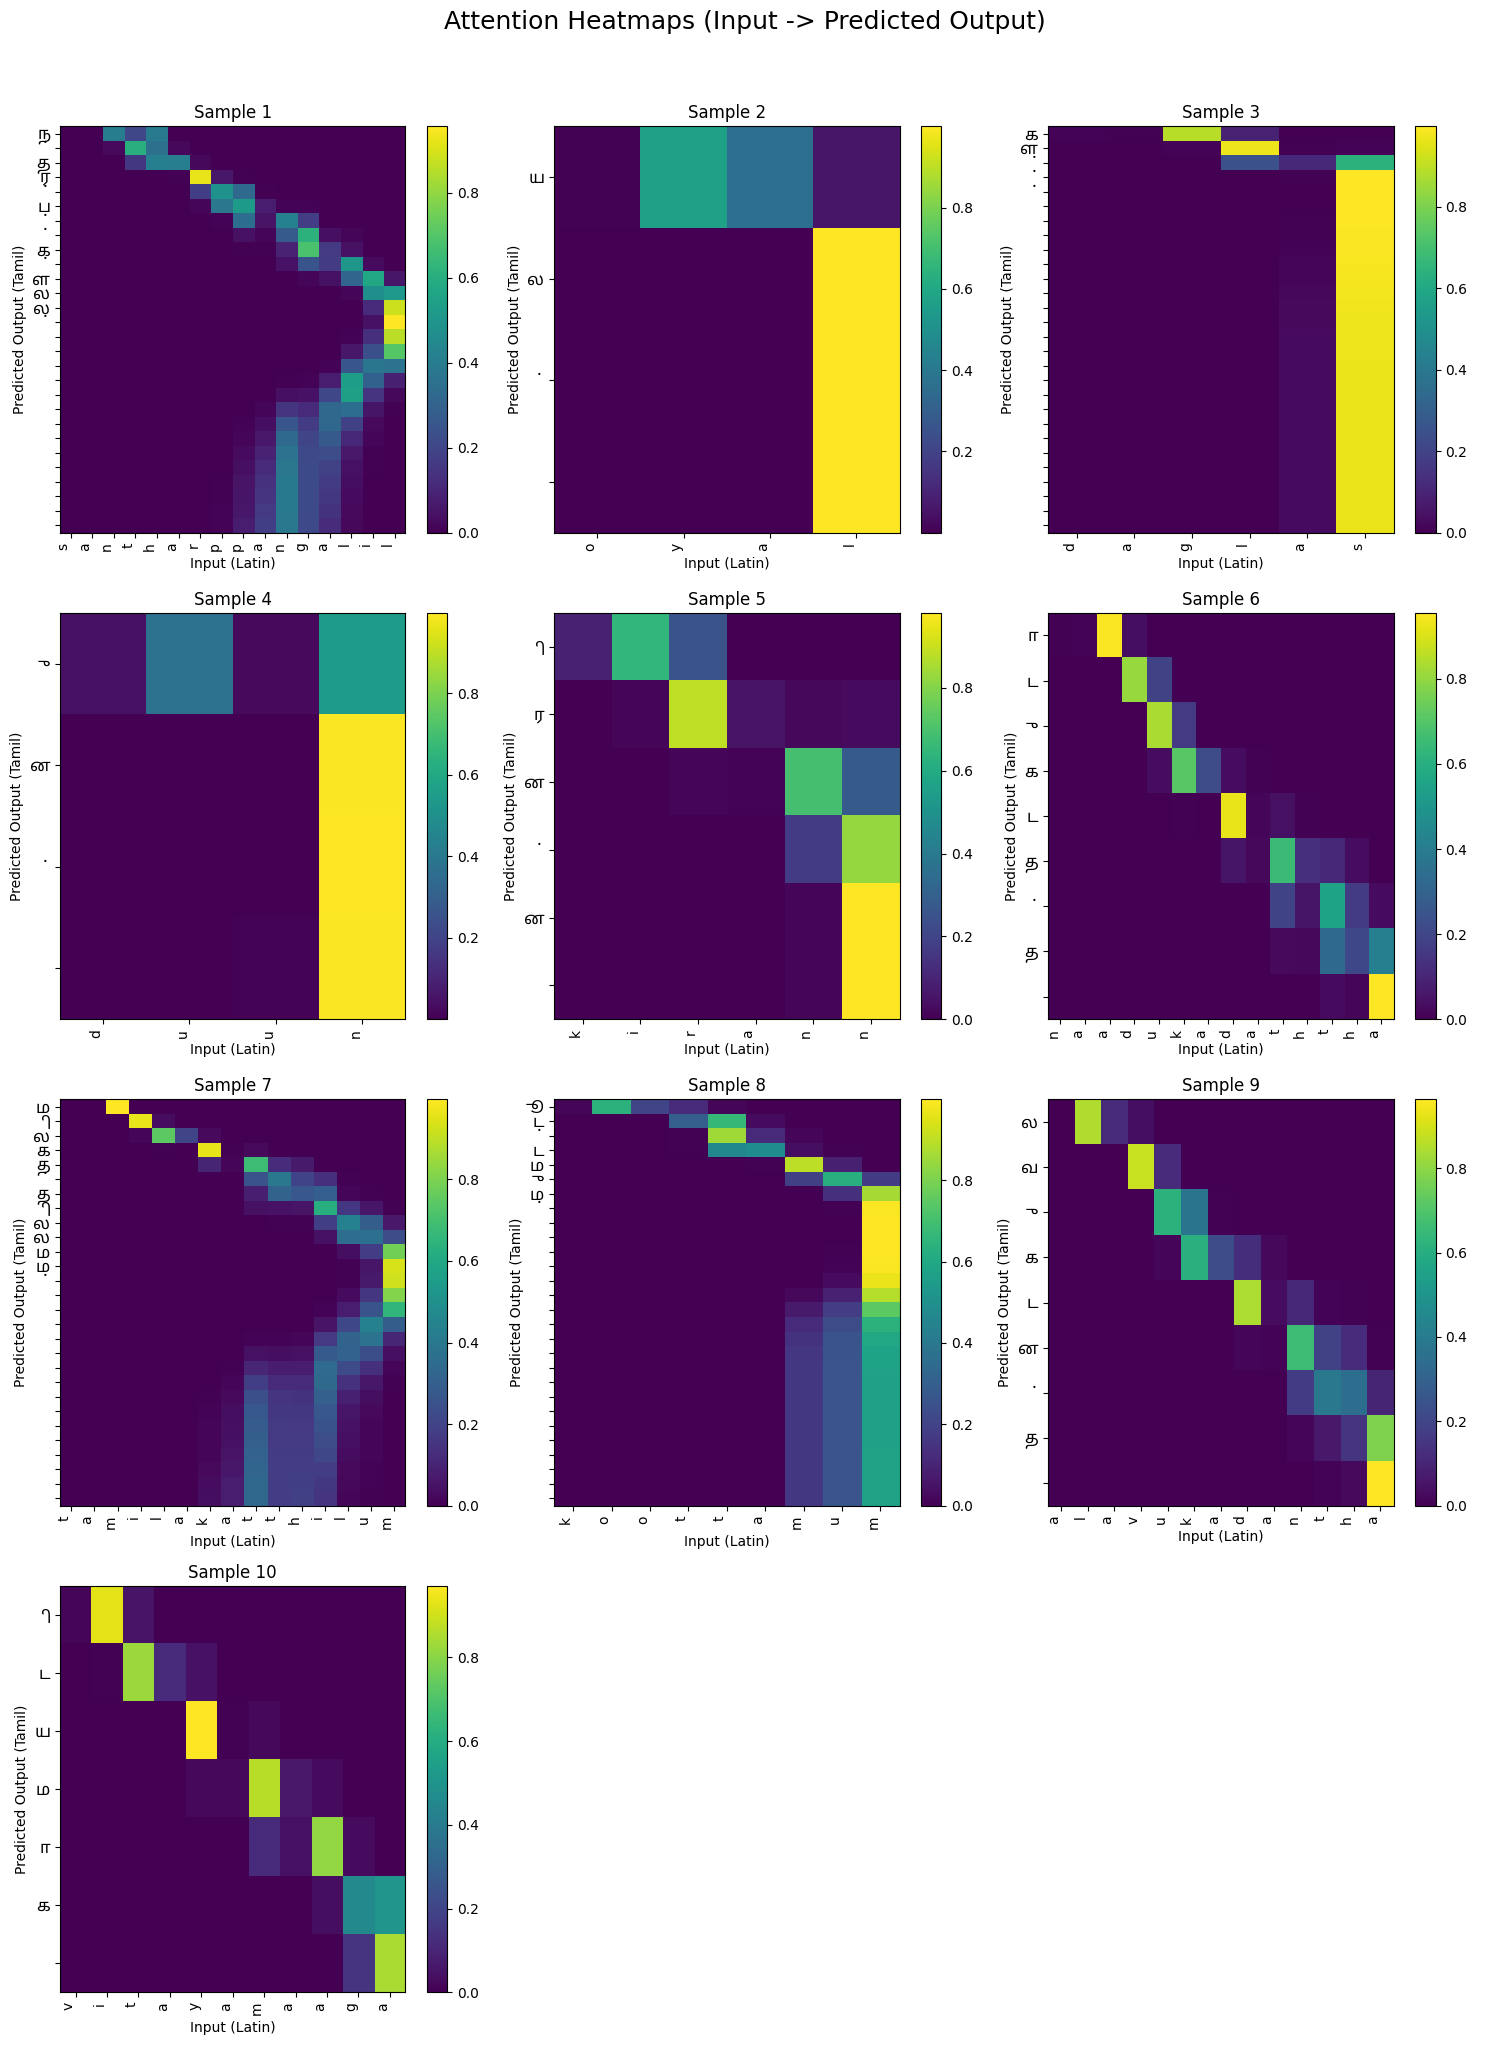

In [20]:
# Function to get attention weights for a single sample
def get_attention_weights(model, src_tensor, src_len, trg_tensor, max_len=20):
    model.eval()
    with torch.no_grad():
        src_tensor = src_tensor.unsqueeze(0).to(device)  # Add batch dimension
        src_len_tensor = torch.tensor([src_len], dtype=torch.long).to(device)
        trg_tensor = trg_tensor.unsqueeze(0).to(device) # Add batch dimension

        # Encode input
        encoder_outputs, hidden = model.encoder(src_tensor, src_len_tensor)

        # Initialize decoder hidden state
        if model.decoder.cell_type == 'LSTM':
            if isinstance(hidden, tuple):
                decoder_hidden = (hidden[0][-model.decoder.rnn.num_layers:],
                                 hidden[1][-model.decoder.rnn.num_layers:])
            else:
                decoder_hidden = (hidden[-model.decoder.rnn.num_layers:],
                                 hidden[-model.decoder.rnn.num_layers:])
        else:
            if isinstance(hidden, tuple):
                decoder_hidden = hidden[0][-model.decoder.rnn.num_layers:]
            else:
                decoder_hidden = hidden[-model.decoder.rnn.num_layers:]

        # Start with SOS token
        input = torch.full((1,), SOS_token, dtype=torch.long).to(device)

        attention_weights_list = []
        predicted_indices = []

        # Assuming target_char_decoder exists and SOS_token is its index
        target_char_decoder = {v: k for k, v in target_char_enc.items()}
        output_vocab_size = len(target_char_enc)


        # Decode step by step
        for t in range(max_len):
            # Extract appropriate hidden state for attention calculation
            if isinstance(decoder_hidden, tuple): # If hidden is (h, c)
                 h_attn = decoder_hidden[0][-1] # (batch, hidden_dim)
            else: # If hidden is just h
                 h_attn = decoder_hidden[-1] # (batch, hidden_dim)

            # Calculate attention weights
            attn_weights = model.decoder.attention(h_attn, encoder_outputs).squeeze(0) # (src_len)
            attention_weights_list.append(attn_weights.cpu().numpy())

            # Calculate context vector (not strictly needed for heatmap, but part of decoder)
            context = torch.bmm(attn_weights.unsqueeze(0).unsqueeze(0), encoder_outputs).squeeze(1) # (1, hidden_dim)

            # Decoder RNN input
            embedded = model.decoder.embedding(input).unsqueeze(1) # (1, 1, embed_dim)
            # Ensure context has correct shape (batch_size, seq_len, hidden_dim) for concatenation
            # It should be (1, 1, hidden_dim) for this step
            context = context.unsqueeze(1) # (1, 1, hidden_dim)
            rnn_input = torch.cat((embedded, context), dim=2) # (1, 1, embed + hidden)


            # Prepare hidden state for the decoder RNN
            # The shape of decoder_hidden needs to be (num_layers, batch_size, hidden_dim) for RNN/GRU
            # or ((num_layers, batch_size, hidden_dim), (num_layers, batch_size, hidden_dim)) for LSTM
            # Ensure the decoder's RNN expects num_layers in the first dimension if batch_first=True
            # based on the model definition, RNN expects (batch, seq_len, hidden_size) input
            # and (num_layers * num_directions, batch, hidden_size) for hidden state
            # Our current `decoder_hidden` has shape (num_layers, batch_size, hidden_dim) or tuple of that
            # which matches the expected hidden state format when batch_first=True is used in RNN/GRU/LSTM.
            # So, no change needed here unless the RNN definition changes.
            hidden_rnn = decoder_hidden


            # Decode one step
            output, decoder_hidden = model.decoder.rnn(rnn_input, hidden_rnn)

            # Predict output character
            # Concatenate output and context before final linear layer
            # output shape from RNN: (1, 1, hidden_dim)
            # context shape: (1, 1, hidden_dim) - from above unsqueeze(1)
            # Need to squeeze seq_len dimension before concatenation for fc_out
            output = model.decoder.fc_out(torch.cat((output.squeeze(1), context.squeeze(1)), dim=1)) # (1, vocab_size)

            top1 = output.argmax(1) # (1)

            predicted_indices.append(top1.item())

            # Stop if EOS token is predicted
            if top1.item() == EOS_token:
                 break

            input = top1 # Use prediction as next input


        # Convert list of weights to a numpy array (trg_len, src_len)
        attention_weights = np.array(attention_weights_list)

        # Get corresponding predicted tokens (excluding SOS)
        # Ensure target_char_decoder is accessible
        if 'target_char_enc' in globals():
             target_char_decoder = {v: k for k, v in target_char_enc.items()}
        else:
             print("Warning: target_char_enc not found. Cannot decode predicted tokens.")
             target_char_decoder = {} # Use empty dict if not found


        predicted_tokens = [target_char_decoder.get(idx, '?') for idx in predicted_indices]


        return attention_weights, predicted_tokens

# Select 10 random samples from the test set for visualization
# Ensure test_loader is accessible
if 'test_loader' in globals() and test_loader is not None and len(test_loader.dataset) > 0:
    sample_indices = random.sample(range(len(test_loader.dataset)), min(10, len(test_loader.dataset))) # Ensure we don't sample more than available
    samples_to_visualize = [test_loader.dataset[i] for i in sample_indices]
    print(f"\n--- Generating Attention Heatmaps for {len(samples_to_visualize)} Samples ---")
else:
    samples_to_visualize = []
    print("\nWarning: Test loader dataset is empty or not available. Cannot generate heatmaps.")


# Setup plot for 3x3 grid
n_cols = 3
n_rows = -(-len(samples_to_visualize) // n_cols) # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = axes.flatten() # Flatten to easily iterate


# Loop through samples and plot
for i, (src_tensor, trg_inp_tensor, trg_target_tensor) in enumerate(samples_to_visualize):
    # Get attention weights and predicted tokens
    # Ensure PAD_token is accessible
    if 'PAD_token' in globals():
        src_len = (src_tensor != PAD_token).sum().item()
    else:
        # Assume full length if PAD_token is not defined
        src_len = src_tensor.size(0)
        print("Warning: PAD_token not found. Assuming full source length for heatmap.")


    # Ensure model_attn and max_decoder_seq_length are accessible
    if 'model_attn' in globals() and model_attn is not None and 'max_decoder_seq_length' in globals():
        attention_weights, predicted_tokens = get_attention_weights(model_attn, src_tensor, src_len, trg_inp_tensor, max_len=max_decoder_seq_length)
    else:
        print(f"Error: model_attn or max_decoder_seq_length not available for sample {i+1}. Skipping heatmap.")
        continue


    # Decode input string
    input_text_indices = src_tensor.tolist()[:src_len] # Only take up to the actual length
    # Corrected: Use list indexing for input_char_dec
    # Ensure input_char_dec is accessible
    if 'input_char_dec' in globals():
        input_tokens = [input_char_dec[idx] if 0 <= idx < len(input_char_dec) else '?' for idx in input_text_indices if 'PAD_token' in globals() and idx != PAD_token]
    else:
         print("Warning: input_char_dec not found. Cannot decode input tokens.")
         input_tokens = [str(idx) for idx in input_text_indices if 'PAD_token' in globals() and idx != PAD_token] # Use indices as strings


    # Remove trailing blank tokens from predicted tokens for visualization
    # Ensure PAD_token and EOS_token are accessible
    ignore_for_viz = set()
    if 'PAD_token' in globals() and 'target_char_decoder' in locals():
        ignore_for_viz.add(target_char_decoder.get(PAD_token, '?'))
    if 'EOS_token' in globals() and 'target_char_decoder' in locals():
         ignore_for_viz.add(target_char_decoder.get(EOS_token, '?'))

    while predicted_tokens and predicted_tokens[-1] in ignore_for_viz:
        predicted_tokens.pop()

    # Plot the heatmap
    ax = axes[i]
    # Ensure attention_weights is not empty before plotting
    if attention_weights.shape[0] > 0 and attention_weights.shape[1] > 0:
        cax = ax.imshow(attention_weights, cmap='viridis', aspect='auto')
        fig.colorbar(cax, ax=ax)
    else:
        ax.text(0.5, 0.5, "No Attention Data", horizontalalignment='center', verticalalignment='center')
        print(f"Warning: Attention weights shape is {attention_weights.shape} for sample {i+1}. Cannot plot heatmap.")
        continue # Skip plotting for this sample

    # Set labels
    ax.set_xticks(np.arange(len(input_tokens)))
    ax.set_yticks(np.arange(len(predicted_tokens)))
    ax.set_xticklabels(input_tokens)
    # Ensure tamil_font is accessible
    try:
        ax.set_yticklabels(predicted_tokens, fontproperties=tamil_font) # Use Tamil font for output labels
    except:
        print("Warning: Could not set yticklabels with tamil_font. Using default font.")
        ax.set_yticklabels(predicted_tokens)


    # Rotate input labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right")

    ax.set_xlabel("Input (Latin)")
    ax.set_ylabel("Predicted Output (Tamil)")
    ax.set_title(f"Sample {i+1}")


# Hide any unused subplots
for j in range(len(samples_to_visualize), len(axes)):
    axes[j].axis('off')


plt.suptitle("Attention Heatmaps (Input -> Predicted Output)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()